In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time as timer
import scipy, matplotlib
import frequencies, mixed_modes_utils
import sys
import plotly.express as px

sys.path.append('/home/marc/notebooks/TuRBO/')

from astropy.timeseries import LombScargle
from scipy.stats import qmc
from turbo import Turbo1, TurboM
from turbo.utils import from_unit_cube, latin_hypercube, to_unit_cube
from sklearn.neighbors import KDTree
from plotly.colors import sample_colorscale
from jupyter_dash import JupyterDash
from copy import deepcopy
import dash
import dash_core_components as dcc
import dash_html_components as html

JupyterDash.infer_jupyter_proxy_config()

In [3]:
#' It is assumed that DeltaNu is in μHz
def DeltaPi1_from_DeltaNu_RGB(DeltaNu):
    # Compute Period spacing (in s) from deltanu
    return 60 + 1.7*DeltaNu

def Lor_model(pds, peak):
    return peak.height / (1 + ((pds.frequency.values - peak.frequency)/peak.linewidth)**2)

def sinc2_model(pds, peak):
    deltanu = np.mean(np.diff(pds.frequency.values))
    return peak.height * np.sinc((pds.frequency.values - peak.frequency)/deltanu)**2

def fit_model(pds, peaks):

    model = np.ones_like(pds.frequency.values)

    for i in range(len(peaks)):
        if np.isfinite(peaks.linewidth.iloc[i]):
            model += Lor_model(pds, peaks.iloc[i,])
        else:
            model += sinc2_model(pds, peaks.iloc[i, ])
    return model

In [4]:
from scipy.stats import chi2

def psps_significance(DPi1, q):

    params = {'calc_l0': True, # Compute radial mode properties
            'calc_l2': True, # Compute l=2 mode properties
            'calc_l3': False, # Don't need to calculate l=3 theoretical freqs
            'calc_nom_l1': True, # Compute nominal l=1 p-mode properties
            'calc_mixed': False, # Don't compute mixed modes (as not needed)
            'calc_rot': False, # Don't compute rotation
            'DPi1': DPi1,
            'coupling': q,
            'eps_g': 0.0, # Epsilon_g isn't needed for computation of tau due to chosen formulation of zeta
            'l': 1, # Mixed modes are dipole mixed modes
            }
    freqs(params)
    new_frequency, tau, zeta = mixed_modes_utils.stretched_pds(pds_l023_removed.frequency.values, 
                                                               freqs.zeta)

    f = np.arange(1/(400.), 1/(20.), 0.1/tau.max())
    ls = LombScargle(tau, pds_l023_removed.power.values)
    PSD_LS = ls.power(f)

    noise = np.median(PSD_LS) / (1 - 1/9)**3
   
    # Cut down period and power arrays to search range if given
    cut_PSD_LS = PSD_LS[(1/f > 20) & (1/f < 400)]

    # Report significance level of highest peak in search area
    sig_prob = chi2.cdf((cut_PSD_LS/noise)[np.argmin(np.abs((1/f) - DPi1))], df=2) # try 
    print('SIG PROB WHEE')
    return sig_prob



def prepare_l1_peaks(peaks: pd.DataFrame, summary: pd.DataFrame,
                     AIC_cut: [float] = 0.0, height_cut: [float] = 0.0) -> pd.DataFrame:
    """
    Extract the mixed modes from the peaks dataframe.
    
    Parameters
    ----------
    peaks: pd.DataFrame
        Dataframe containing the detected peaks and parameters.
        
    summary: pd.DataFrame
        Dataframe containing the global stellar information.
    
    AIC_cut: Optional[float] = 0.0
        Cut to make in the Akaike Information Criterion if desired.
        
    height_cut: Optional[float] = 0.0
        Cut to make in the mode height if desired.
        
    Outputs
    -------
    pd.DataFrame
        Dataframe containing the mixed mode peaks and associated mode parameters.
    """
    peaks['x'] = ((peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1
    # Don't want to include any modes near l=0 or 2s, this is why this and the step in the next cell is performed.
    x_range = [(np.minimum(np.min(peaks.loc[peaks['l'] == 0, 'x']), np.min(peaks.loc[peaks['l'] == 2, 'x'])) - 0.05) % 1,
               (np.maximum(np.max(peaks.loc[peaks['l'] == 0, 'x']), np.max(peaks.loc[peaks['l'] == 2, 'x'])) + 0.05) % 1]
    
    l1_peaks = peaks.loc[(peaks.l == 1) | ~np.isfinite(peaks.l), ]
    l1_peaks['x'] = ((l1_peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1
    if x_range[0] < x_range[1]:
        l1_peaks = l1_peaks.loc[(l1_peaks['x'] < x_range[1]) | (l1_peaks['x'] > x_range[0]), ] # changed to OR for HeB
    else:
        print(x_range)
        l1_peaks = l1_peaks.loc[(l1_peaks['x'] > x_range[1]) & (l1_peaks['x'] < x_range[0]), ]


    l1_peaks = l1_peaks.loc[(l1_peaks['height'] > height_cut), ]
    l1_peaks = l1_peaks.loc[(l1_peaks['AIC'] > AIC_cut), ]

    return l1_peaks

In [5]:
# Load up the summary file, power spectrum and detected peaks
# '/home/marc/notebooks/sloscillations/sloscillations/test_data/KIC1569842/summary.csv'

kicx = 3749487

#### TACO-Mosser ####
summary = pd.read_csv('/home/marc/notebooks/sloscillations/sloscillations/test_data/TACO_Mosser2018_full_peakbagging/00%d/summary.csv' %kicx)
pds = pd.read_csv('/home/marc/notebooks/sloscillations/sloscillations/test_data/TACO_Mosser2018_full_peakbagging/00%d/pds_bgr.csv' %kicx)
peaks = pd.read_csv('/home/marc/notebooks/sloscillations/sloscillations/test_data/TACO_Mosser2018_full_peakbagging/00%d/peaksMLE.csv' %kicx)

#### Charlotte's 8 Test Stars ####
# summary = pd.read_csv('/home/marc/notebooks/sloscillations/sloscillations/test_data/KIC%d/summary.csv' %kicx)
# pds = pd.read_csv('/home/marc/notebooks/sloscillations/sloscillations/test_data/KIC%d/pds_bgr.csv' %kicx)
# peaks = pd.read_csv('/home/marc/notebooks/sloscillations/sloscillations/test_data/KIC%d/peaksMLE.csv' %kicx)


prepped_l1_peaks = prepare_l1_peaks(peaks, summary=summary, AIC_cut=5)

# Only keep pds around oscillations
pds = pds.loc[abs(pds['frequency'].values - summary['numax'].values) < 3 * summary['sigmaEnv'].values, ]

# # If ΔΠ1 is in mega seconds then convert to seconds
# if summary['DeltaPi1'].values < 1:
#     summary['DeltaPi1'] *= 1e6

# Read in and filter peaks file to be within +/-3 sigmaEnv of numax
peaks = peaks.loc[abs(peaks.frequency.values - summary.numax.values) < 3*summary.sigmaEnv.values, ]

# Split the peaks in the l=0,2,3 peaks (which have been already identified)
# and the rest, which should hopefully be unidentified l=3
l023_peaks = peaks.loc[(peaks.l == 0) | (peaks.l == 2) | (peaks.l == 3)]
l0_peaks = peaks.loc[(peaks.l==0), ]
l1_peaks = peaks.loc[(peaks.l == 1)  | (np.isfinite(peaks.l) == False)]
l2_peaks = peaks.loc[(peaks.l==2), ]

[0.9580882446458328, 0.03814050678624881]


<ipython-input-4-84bcaa3212b0>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1_peaks['x'] = ((l1_peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1


In [6]:
print(len(prepped_l1_peaks))
print(len(l1_peaks))

60
82


In [7]:
## Removed l=1 frequencies
rem1 = l1_peaks[~l1_peaks['frequency'].isin(prepped_l1_peaks['frequency'])][['frequency', 'x', 'AIC']]
print(rem1)
## l=0 frequencies
print(l0_peaks[['frequency', 'x']])
## l=2 frequencies
print(l2_peaks[['frequency', 'x']])

     frequency         x       AIC
20   46.549926  0.995147  2.385262
23   50.426931  0.592634  4.402994
24   51.973892  0.831036  3.055191
25   53.475878  0.062508  2.725758
26   55.304961  0.344389  4.976262
35   62.149769  0.399245  2.880272
42   63.731873  0.643063  2.883555
47   68.918868  0.442433  3.621493
55   70.422055  0.674090  2.733532
58   72.074341  0.928724  2.511413
59   74.661465  0.327427  3.918155
69   76.662379  0.635788  2.816112
70   77.049661  0.695473  4.871222
72   80.434206  0.217066  3.894598
83   88.341458  0.435656  3.990689
84   88.558758  0.469144  3.701226
87   89.420744  0.601985  3.609143
89   90.381285  0.750014  2.335817
91   91.410110  0.908567  3.605494
92   91.945640  0.991097  2.203616
93   93.392165  0.214022  2.649952
100  99.202871  0.109512  3.797327
    frequency         x
1   53.302718  0.035822
3   59.453245  0.983682
5   65.950843  0.985030
8   72.442695  0.985491
11  78.948741  0.988141
14  85.652577  0.021271
16  92.291005  0.044322
   

In [8]:
plt.plot(pds['frequency'], fit_model(pds, l023_peaks))

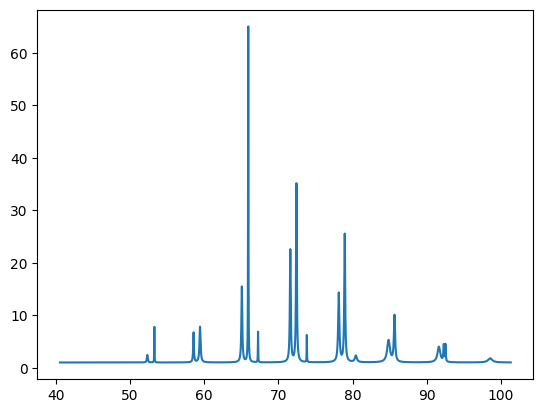

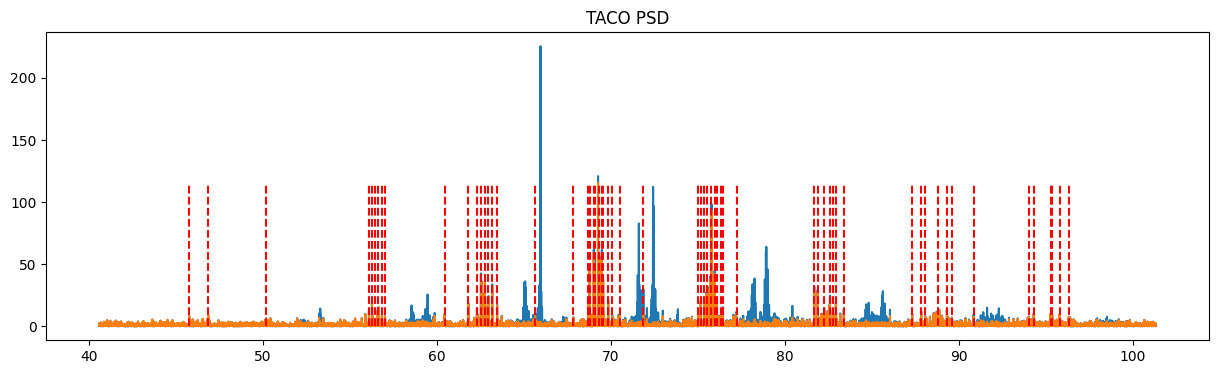

In [9]:
# Divide the data through by the model of the l=0,2 modes
pds_l023_removed = pds.assign(power = pds.power / fit_model(pds, l023_peaks))

fig = plt.figure(figsize=(15, 4))

plt.plot(pds.frequency.values, pds.power.values, label='Original')
plt.plot(pds.frequency.values, pds_l023_removed.power.values, label='Dipole Only')
plt.vlines(prepped_l1_peaks.frequency.values,ymin=0, ymax=np.max(pds_l023_removed.power.values),
           color='r', ls='--')
plt.title('TACO PSD')
# plt.ylim(0, 20)
# plt.xlim(138, 142)

plt.show()

In [10]:
# Create artificial frequencies for creation of stretched power spectrum using values determined from TACO for this star
freqs = frequencies.Frequencies(frequency=pds_l023_removed.frequency.values,
                                numax=summary.numax.values, 
                                delta_nu=summary.DeltaNu.values if np.isfinite(summary.DeltaNu.values) else None, 
                                epsilon_p=summary.eps_p.values if np.isfinite(summary.eps_p.values) else None,
                                alpha=summary.alpha.values if np.isfinite(summary.alpha.values) else None)

In [11]:
# Initial PSxPS to assess starting point and range for Bayesian Optimisation

# Scaling Guess (RGB only)
print('Scaling Guess: ', DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu))

up_bound, low_bound = 200, 20 # RGB
# up_bound, low_bound = 400, 100 # HeB

params = {'calc_l0': True, # Compute radial mode properties
            'calc_l2': True, # Compute l=2 mode properties
            'calc_l3': False, # Don't need to calculate l=3 theoretical freqs
            'calc_nom_l1': True, # Compute nominal l=1 p-mode properties
            'calc_mixed': False, # Don't compute mixed modes (as not needed)
            'calc_rot': False, # Don't compute rotation
            'DPi1': DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu),
            'coupling': 0.2,
            'eps_g': 0.0, # Epsilon_g isn't needed for computation of tau due to chosen formulation of zeta
            'l': 1, # Mixed modes are dipole mixed modes
            }
freqs(params)

if pds_l023_removed.frequency.min() < freqs.l0_freqs.min():
    zeta = freqs.zeta[pds_l023_removed.frequency >= freqs.l0_freqs.min()]
    power = pds_l023_removed.power[pds_l023_removed.frequency >= freqs.l0_freqs.min()].values
    freq = pds_l023_removed.frequency[pds_l023_removed.frequency >= freqs.l0_freqs.min()].values
else:
    power = pds_l023_removed.power.values
    freq = pds_l023_removed.frequency.values
    zeta = freqs.zeta

new_frequency, tau, zeta = mixed_modes_utils.stretched_pds(freq, 
                                                           zeta)
# start, bad1, good1, best, bad2, bad3, bad4

fr = np.arange(1/(up_bound), 1/(low_bound), 0.1/tau.max()) # 150, 20 for RGB; 400, 150 for RC

ls = LombScargle(tau, power)
PSD_LS = ls.power(fr)
noise = np.median(PSD_LS) / (1 - 1/9)**3
plt.figure(figsize=(20, 8))
plt.plot(1/fr, PSD_LS)

dpi1_guess = (1/fr)[np.argmax(PSD_LS)]

bad1_power, bad1_period = PSD_LS, 1/fr

print('Above: ', np.std((1/fr)[PSD_LS/noise > np.percentile(PSD_LS, 99.5)]))

print(f"Best guess DPi1 from PSxPS is {dpi1_guess} s with a maximum of {np.max(PSD_LS)*1000.}")

Scaling Guess:  [71.03105473]
Above:  37.148705300575934
Best guess DPi1 from PSxPS is 68.64683972687467 s with a maximum of 5.244383074800315


In [13]:
class PSXPS:
    def __init__(self, init_dpi, low_bound, up_bound, factor=1):
        
        self.factor = factor
        init_dpi = init_dpi*self.factor
        
        self.lb = np.array([0.8*init_dpi, 0])
        self.ub = np.array([1.2*init_dpi, 0.6])
        self.low_bound = low_bound
        self.up_bound = up_bound
        
    def __call__(self, x):
        assert len(x) == 2
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        DPi1, q = x[0], x[1]
        
        params = {'calc_l0': True, 
                'calc_l2': True, 
                'calc_l3': False, 
                'calc_nom_l1': True,
                'calc_mixed': False, 
                'calc_rot': False,
                'DPi1': DPi1,
                'coupling': q,
                'eps_g': 0.0,
                'l': 1,
                }
        freqs(params)
        
        if pds_l023_removed.frequency.min() < freqs.l0_freqs.min():
            zeta = freqs.zeta[pds_l023_removed.frequency >= freqs.l0_freqs.min()]
            power = pds_l023_removed.power[pds_l023_removed.frequency >= freqs.l0_freqs.min()].values
            freq = pds_l023_removed.frequency[pds_l023_removed.frequency >= freqs.l0_freqs.min()].values
        else:
            power = pds_l023_removed.power.values
            freq = pds_l023_removed.frequency.values
            zeta = freqs.zeta
        
        new_frequency, tau, zeta = mixed_modes_utils.stretched_pds(freq, 
                                                                   zeta)

        f = np.arange(1/(self.up_bound), 1/(self.low_bound), 0.1/tau.max())
        ls = LombScargle(tau, power)
        PSD_LS = ls.power(f)
#         noise = np.median(PSD_LS) / (1 - 1/9)**3
        cut_PSD_LS = PSD_LS[(1/f > self.low_bound) & (1/f < self.up_bound)]
        cut_f = f[(1/f > self.low_bound) & (1/f < self.up_bound)]
        
        return -(cut_PSD_LS*1000.)[np.argmin(np.abs((1/cut_f) - (1./self.factor)*DPi1))]

if dpi1_guess < 30:
    factor = 3.
elif dpi1_guess < 50:
    factor = 2
else:
    factor = 1
    
f = PSXPS(init_dpi = dpi1_guess, up_bound=up_bound, low_bound=low_bound, factor = factor)

In [14]:
turbo1 = Turbo1(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=100,  # Number of initial bounds from an Latin hypercube design
    max_evals =2000,  # Maximum number of evaluations
    batch_size=25,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=64,  # Run on the CPU for small datasets
    device="cuda",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32,
)

Using dtype = torch.float64 
Using device = cuda


In [15]:
import torch
torch.cuda.is_available()

True

In [16]:
init_time = timer.time()
turbo1.optimize()
print('Elapsed Time: ', timer.time()-init_time)

Starting from fbest = -5.176


/home/marc/anaconda3/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:124: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2191.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


150) New best: -5.22 Solution: [65.46035235  0.15943204]
175) New best: -5.681 Solution: [68.39661567  0.12746912]
200) New best: -5.916 Solution: [68.51231703  0.13540263]
275) New best: -5.956 Solution: [68.46958868  0.12027301]
300) New best: -6.0 Solution: [68.49870755  0.12192836]
325) New best: -6.028 Solution: [68.54375491  0.10294428]
350) New best: -6.043 Solution: [68.53287105  0.11385674]


KeyboardInterrupt: 

In [39]:
X = turbo1.X  # Evaluated points
fX = turbo1.fX.ravel()  # Observed values
# X.shape, fX.shape
ind_best = np.argmin(fX)
f_best, x_best = fX[ind_best], X[ind_best, :]

print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))

Best value found:
	f(x) = -6.044
Observed at:
	x = [68.524  0.111]


# Sobol sampling

In [37]:
# SOBOL SAMPLING!!
sampler = qmc.Sobol(d=2, scramble=True)
sample = sampler.random_base2(m=11)
# l_bounds = [dpi1_lower, 0]
# u_bounds = [dpi1_upper, 0.8]
samples = qmc.scale(sample, f.lb, f.ub)
idx = np.argsort(samples[:,0])
samp_sob = samples[idx]

samples = to_unit_cube(samp_sob, f.lb, f.ub)
samples

assert samples.min() >= 0.0 and samples.max() <= 1.0

In [38]:
import torch, gpytorch
# We use Lanczos for sampling if we have enough data
with torch.no_grad(), gpytorch.settings.max_cholesky_size(turbo1.max_cholesky_size):
    X_cand_torch = torch.tensor(samples).cuda()#.to(device=device, dtype=dtype)
    
    y_cand = turbo1.best_gp.likelihood(turbo1.best_gp(X_cand_torch))#.sample(torch.Size([10])).t().cpu().detach().numpy()

In [33]:
df = pd.DataFrame({'DPi1': X[:,0], 'q': X[:,1], 'Loss': fX, 'sample_type': 'BayesOpt'})
df_sobol = pd.DataFrame({'DPi1': samp_sob[:,0], 'q': samp_sob[:,1], 'Loss': y_cand.mean.data.cpu().numpy(),
                        'sample_type': 'Sobol'})

df_comb = pd.concat([df, df_sobol])
# df_comb.to_csv('%d_psps.csv' %kicx, index=False)

NameError: name 'X' is not defined

In [32]:
df.DPi1.values[np.argsort(df.Loss.values)[len(df)//2]], df.q.values[np.argsort(df.Loss.values)[len(df)//2]]

NameError: name 'df' is not defined

In [31]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

server = app.server

app.layout = html.Div([
    
    html.Div([dcc.RadioItems(
                id='sample_type',
                options=[{'label': i, 'value': i} for i in ['BayesOpt', 'Sobol']],
                value='BayesOpt',
                labelStyle={'display': 'inline-block'}
            )
        ],
        style={'width': '95%', 'display': 'inline-block',
               'borderBottom': 'thin lightgrey solid',
        'backgroundColor': 'rgb(250, 250, 250)',
              }),
    
    
    html.Div([
        dcc.Graph(#figure=fig,
            id='turbo_samples',
            hoverData={'points': [{'x': df.DPi1.values[np.argsort(df.Loss.values)[len(df)//2]],
                                  'y': df.q.values[np.argsort(df.Loss.values)[len(df)//2]] }]}
        )
    ], style={'width': '49%', 'display': 'inline-block', 'padding': '0 20'}),
    
    html.Div([
        dcc.Graph(id='global_psps'),
        dcc.Graph(id='local_psps')
    ], style={'display': 'inline-block', 'width': '49%'}),
    

])



def create_psps(dpi, q, local=False):
    
    up_bound, low_bound = 200, 20 # RGB
    # up_bound, low_bound = 400, 100 # HeB

    params = {'calc_l0': True, 
                'calc_l2': True,
                'calc_l3': False, 
                'calc_nom_l1': True, 
                'calc_mixed': False,
                'calc_rot': False, 
                'DPi1': dpi,
                'coupling': q,
                'eps_g': 0.0, 
                'l': 1,
                }
    freqs(params)

    if pds_l023_removed.frequency.min() < freqs.l0_freqs.min():
        zeta = freqs.zeta[pds_l023_removed.frequency >= freqs.l0_freqs.min()]
        power = pds_l023_removed.power[pds_l023_removed.frequency >= freqs.l0_freqs.min()].values
        freq = pds_l023_removed.frequency[pds_l023_removed.frequency >= freqs.l0_freqs.min()].values
    else:
        power = pds_l023_removed.power.values
        freq = pds_l023_removed.frequency.values
        zeta = freqs.zeta

    new_frequency, tau, zeta = mixed_modes_utils.stretched_pds(freq, 
                                                               zeta)

    fr = np.arange(1/(up_bound), 1/(low_bound), 0.1/tau.max()) 
    ls = LombScargle(tau, power)
    PSD_LS = ls.power(fr)
    return 1/fr, PSD_LS
    
def format_psps(period, PSD_LS, dpi, q, click_period, click_power, tracecolor, click_tracecolor, local=False):
    
    if not local:
        xrange= [20, 150]
        titletext="Global"
        topm = 40
        xtitle=0.87
        xannot = 0.74
    else:
        xrange= [min(df.DPi1), max(df.DPi1)]
        titletext="Local"
        topm = 40  
        xtitle=0.853
        xannot= 0.732

    if len(click_period) == 0:
        data_ = [dict(
            x=period,
            y=PSD_LS,
            mode='line',
            line={'color': tracecolor,
                 'width': 2,
                 'coloraxis': 'coloraxis'},
            hovertemplate =
            '<b>DPi1</b>: %{x:.1f}s'+
            '<br><b>Power</b>: %{y:.4f}<extra></extra>', #<extra></extra> removes the 'Trace 0' in the hover
        )]
       
    else:
        data_ = [dict(
            x=period,
            y=PSD_LS,
            mode='line',
            line={'color': tracecolor,
                 'width': 2,
                 'coloraxis': 'coloraxis'},
            name='Current',
            hovertemplate =
            '<b>DPi1</b>: %{x:.1f}s'+
            '<br><b>Power</b>: %{y:.4f}<extra></extra>',
            showlegend = False

        ),
                dict(
            x=click_period,
            y=click_power,
            mode='line',
            line={'color': click_tracecolor,
                 'width': 2,
                 'coloraxis': 'coloraxis',
                 'dash': 'dash'},
            name='Focus',
            hovertemplate =
            '<b>DPi1</b>: %{x:.1f}s'+
            '<br><b>Power</b>: %{y:.4f}<extra></extra>',
            showlegend = False
        )]
        

    return {
        'data': data_,
        
        'layout': {
            'annotations': [{'x': 0.65, 'y': 0.75, 'xanchor': 'left', 'yanchor': 'bottom',
                'xref': 'paper', 'yref': 'paper', 'showarrow': False,
                'align': 'left', 'bgcolor': 'rgba(255, 255, 255, 0.5)',
                'text': ' PSxPS %s<br> Period Spacing: %.2fs<br> Coupling Factor: %.3f' %(titletext, dpi, q)
            }],

            'yaxis': {'type': 'linear',
                     "title": {'text': "Power", 'standoff': 1},
                     "range": [0, 0.006]},
            'xaxis': {'showgrid': False, 
                     "title": {'text': "Period Spacing (s)", 'standoff': 1},
                     "range": xrange},
            'hoverlabel': {'bgcolor': 'gray',
                           'namelength': 1,
                          'font': {'color': 'white'}},
            'margin' : {'t': topm, 'b': 40. ,'r': 10, 'l': 50},
            "height": 300,
            'shapes': [{'line': {'color': 'black', 'dash': 'longdashdot', 'width': 1.5},
                 'type': 'line',
                 'x0': dpi,
                 'x1': dpi,
                 'xref': 'x',
                 'y0': 0,
                 'y1': 0.006,
                 'yref': 'y'}],
                     
        }

    }


def format_scatter(df):    
    fig = px.scatter(df, x ='DPi1', y='q', title='Samples',
                color='Loss')
    fig.update_layout(
        yaxis_title='Coupling Factor q',
        xaxis_title='Period Spacing (s)',
        title_x=0.2,
        title_y=0.99,
        title_font_color = 'white',
        plot_bgcolor='ivory',
        height= 600,
        margin={'t': 20, 'l': 40, 'b': 5, 'r': 10}
    )

    fig.update_traces(hovertemplate =
        '<b>DPi1</b>: %{x:.1f}s'+
        '<br><b>q</b>: %{y:.3f}<br>')

    fig.update_xaxes(title_standoff=1, range=[min(df.DPi1), max(df.DPi1)], gridcolor='gainsboro') # Standoff is padding
    fig.update_yaxes(title_standoff=1, range=[min(df.q), max(df.q)], gridcolor='gainsboro') # Standoff is padding
    fig.update_coloraxes(showscale=False)

    return fig


@app.callback(
    dash.dependencies.Output('turbo_samples', 'figure'),
    [dash.dependencies.Input('sample_type', 'value')])
def update_scatter(samplename):
    inp_df = df_comb[df_comb.sample_type == samplename]
    return format_scatter(inp_df) 


@app.callback(
    [dash.dependencies.Output('global_psps', 'figure'), dash.dependencies.Output('local_psps', 'figure')],
    [dash.dependencies.Input('turbo_samples', 'clickData'),
     dash.dependencies.Input('turbo_samples', 'figure'), dash.dependencies.Input('local_psps', 'figure'),
    dash.dependencies.Input('global_psps', 'figure'), dash.dependencies.Input('global_psps', 'clickData')])
def update_psxps(clickData, inp_fig, local_fig, global_fig, global_clickData):

    try:
        dpi_value = clickData['points'][0]['x']
        q_value = clickData['points'][0]['y']
    except:
        dpi_value =  df.DPi1.values[np.argsort(df.Loss.values)[len(df)//2]]
        q_value = df.q.values[np.argsort(df.Loss.values)[len(df)//2]]

    colorlist = inp_fig['data'][0]['marker']['color'] # loss values
    period, PSD_LS = create_psps(dpi_value, q_value)

    try:      
        markercol =  clickData['points'][0]['marker.color']
        _c = (markercol - np.min(colorlist)) / (np.max(colorlist) - np.min(colorlist))
        tracecolor = sample_colorscale(inp_fig['layout']['coloraxis']['colorscale'],
                                       [_c], low=0.0, high=1.0, colortype='rgb')[0]

    except:
        _c = (np.median(colorlist) - np.min(colorlist)) / (np.max(colorlist) - np.min(colorlist))
        tracecolor = sample_colorscale(inp_fig['layout']['coloraxis']['colorscale'],
                                       [_c], low=0.0, high=1.0, colortype='rgb')[0]
        
        
    if local_fig is not None:
        old_dpi, old_q = float(local_fig['layout']['annotations'][0]['text'].split(' ')[5][:5]),\
        float(local_fig['layout']['annotations'][0]['text'].split(' ')[8])
        click_period, click_power = create_psps(old_dpi, old_q)
        click_tracecolor = local_fig['data'][0]['line']['color']
        
    else:
        click_period, click_power, click_tracecolor = [], [], None
    
    
    forz1 = format_psps(period, PSD_LS,dpi_value, q_value, click_period, click_power,
                       tracecolor,click_tracecolor)
    forz2 = format_psps(period, PSD_LS, dpi_value, q_value,
                                                click_period, click_power, tracecolor, click_tracecolor, local=True)
    
            
    return forz1, forz2

NameError: name 'df' is not defined

In [224]:
if 'click_dpi' in globals():
    del click_dpi

if 'clickcount' in globals():
    del clickcount

# del click_period2, click_power2, click_tracecolor2
    
app.run_server(port=8052,debug=True, mode='inline')

# Okay time to analyze rotation

In [22]:
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from CTWED import ctwed


inp_freqs = prepped_l1_peaks['frequency'].values
prepped_l1_peaks['weights'] = (prepped_l1_peaks['amplitude']/np.sum(prepped_l1_peaks['amplitude']))*1000.


class freq_tau_rot:
    def __init__(self, init_dpi):
        self.lb = np.array([init_dpi*0.98, 0.01, -0.4, 0.1]) #or another judicious choice
        self.ub = np.array([init_dpi*1.02, 0.3, 0.4, 0.2]) ## RGB
        
#         self.lb = np.array([init_dpi*0.98, 0.05, -0.5, 0.0]) 
#         self.ub = np.array([init_dpi*1.02, 0.6, 0.2, 0.1]) # HeB
        
    def __call__(self, x):
        assert len(x) == 4
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        dpi1, coupling, eps_g, split = x[0], x[1], x[2], x[3]
        
        
        params = {'calc_l0': True, # copy of params with DPi1 set to candidate dpi from loop
            'calc_l2': True, 
            'calc_l3': False, 
            'calc_nom_l1': True, 
            'calc_mixed': True, 
            'calc_rot': False,
            'DPi1': dpi1,
            'coupling': coupling, 
            'eps_g': eps_g, 
            'split_core': split,
            'split_env': 0.0,
            'l': 1,
            }
    
        freqs(params)

        freqs.generate_tau_values()

        # Compute tau from the zeta value just computed
        real_tau = mixed_modes_utils.peaks_stretched_period(inp_freqs, 
                                                                 freqs.frequency, 
                                                                 freqs.tau)

        freqs_p1 = freqs.l1_mixed_freqs + freqs.l1_zeta * split
        freqs_n1 = freqs.l1_mixed_freqs - freqs.l1_zeta * split

        tau_p1 = mixed_modes_utils.peaks_stretched_period(freqs_p1, freqs.frequency, freqs.tau)
        tau_n1 = mixed_modes_utils.peaks_stretched_period(freqs_n1, freqs.frequency, freqs.tau)

        model_freqs = np.c_[freqs.l1_mixed_freqs, freqs_p1, freqs_n1]
        model_tau = np.c_[freqs.l1_mixed_tau, tau_p1, tau_n1]   


#         # #triplet case
        X = np.c_[np.r_[model_tau[:,0],
                        model_tau[:,1] - freqs.shift * freqs.DPi1, 
                        model_tau[:,2] - freqs.shift * freqs.DPi1], 
                  np.r_[model_freqs[:,0],
                        model_freqs[:,1], 
                        model_freqs[:,2]]]


        y_real = (real_tau - freqs.DPi1*(freqs.shift))
        X_real = np.c_[y_real, inp_freqs]
        
        dist = 0
        # now compute distance between original frequencies with the frequencies under a new model hypothesis

        ## KDTree ##
        c1 = np.vstack((X[:,0]/freqs.DPi1, (X[:,1]-freqs.numax)/freqs.delta_nu)).T
        c2 = np.vstack((X_real[:,0]/freqs.DPi1, (X_real[:,1]-freqs.numax)/freqs.delta_nu)).T
        tree = KDTree(c1, metric='euclidean')
        nearest_dists, nearest_idx = tree.query(c2, k=1)
        dist += np.median(nearest_dists*prepped_l1_peaks['weights'].values)

        return dist
    
class freq_tau_rot_singlet:
    def __init__(self, init_dpi):
        self.lb = np.array([init_dpi*0.98, 0.05, -0.7]) 
        self.ub = np.array([init_dpi*1.02, 0.6, 0.2]) # HeB
        
    def __call__(self, x):
        assert len(x) == 3
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        dpi1, coupling, eps_g = x[0], x[1], x[2]
        
        
        params = {'calc_l0': True, # copy of params with DPi1 set to candidate dpi from loop
            'calc_l2': True, 
            'calc_l3': False, 
            'calc_nom_l1': True, 
            'calc_mixed': True, 
            'calc_rot': False,
            'DPi1': dpi1,
            'coupling': coupling, 
            'eps_g': eps_g, 
            'split_core': 0.0,
            'split_env': 0.0,
            'l': 1,
            }
    
        freqs(params)

        freqs.generate_tau_values()

        # Compute tau from the zeta value just computed
        real_tau = mixed_modes_utils.peaks_stretched_period(inp_freqs, 
                                                                 freqs.frequency, 
                                                                 freqs.tau)


        model_freqs = freqs.l1_mixed_freqs.reshape(-1,1)
        model_tau = freqs.l1_mixed_tau.reshape(-1,1)

        # singlet case  
        X = np.c_[model_tau[:,0], model_freqs[:,0]]    
        y_real = (real_tau - freqs.DPi1*(freqs.shift))
        X_real = np.c_[y_real, inp_freqs]


        y_real = (real_tau - freqs.DPi1*(freqs.shift))
        X_real = np.c_[y_real, inp_freqs]

        # now compute distance between original frequencies with the frequencies under a new model hypothesis

        ### HUNGARIAN ALGORITHM ###
        
        c1 = np.vstack((X[:,0]/freqs.DPi1, (X[:,1]-freqs.numax)/freqs.delta_nu)).T#(X_t[:,1]-freqs.numax)/freqs.delta_nu )).T
        c2 = np.vstack((X_real[:,0]/freqs.DPi1, (X_real[:,1]-freqs.numax)/freqs.delta_nu)).T
        
        cost_matrix = cdist(c1, c2, 'euclidean') 

        row_ind, col_ind = linear_sum_assignment(cost_matrix) # picks minimum distance
        dist = np.median(cost_matrix[row_ind, col_ind]* prepped_l1_peaks['weights'].values[col_ind])# 

        return dist

In [23]:
f_rot = freq_tau_rot(init_dpi = x_best[0])
print(x_best[0])

NameError: name 'x_best' is not defined

In [46]:
turbo1_rot = TurboM(
    f=f_rot,  # Handle to objective function
    lb=f_rot.lb,  # Numpy array specifying lower bounds
    ub=f_rot.ub,  # Numpy array specifying upper bounds
    n_init=50,  # Number of initial bounds from an Symmetric Latin hypercube design
    max_evals=5000,  # Maximum number of evaluations
    n_trust_regions=10,  # Number of trust regions
    batch_size=100,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=64,  # Run on the CPU for small datasets
    device="cuda",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)
turbo1_rot.n_cand = 5000

Using dtype = torch.float64 
Using device = cuda


In [47]:
init_time = timer.time()
turbo1_rot.optimize()
print('Elapsed Time: ', timer.time()-init_time)

TR-0 starting from: 0.8254
TR-1 starting from: 0.8401
TR-2 starting from: 0.994
TR-3 starting from: 0.9715
TR-4 starting from: 1.015
TR-5 starting from: 0.8978
TR-6 starting from: 0.7563
TR-7 starting from: 0.8264
TR-8 starting from: 0.8635
TR-9 starting from: 0.873
800) New best @ TR-6: 0.7427, Best Sol: [69.63763466  0.24174522 -0.38067499  0.11073447]
800) New best @ TR-7: 0.7074, Best Sol: [68.20718554  0.17047266  0.12383481  0.12626661]
1000) New best @ TR-7: 0.6576, Best Sol: [68.21821028  0.15394216  0.10356654  0.12973546]
1100) New best @ TR-7: 0.5698, Best Sol: [6.82287152e+01 1.38037390e-01 6.01301295e-02 1.26961200e-01]
1200) New best @ TR-7: 0.4838, Best Sol: [6.82419705e+01 1.21037887e-01 4.42496666e-02 1.25653501e-01]
1500) New best @ TR-7: 0.4505, Best Sol: [6.82480626e+01 1.13798967e-01 3.19462423e-02 1.24622558e-01]
1600) New best @ TR-7: 0.4414, Best Sol: [6.82510109e+01 1.13957503e-01 2.02357418e-02 1.23920389e-01]
1800) New best @ TR-7: 0.4409, Best Sol: [6.825038

In [65]:
X_rot = turbo1_rot.X  # Evaluated points
fX_rot = turbo1_rot.fX  # Observed values
ind_best_rot = np.argmin(fX_rot)
f_best_rot, x_best_rot = fX_rot[ind_best_rot], X_rot[ind_best_rot, :]

print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best_rot, np.around(x_best_rot, 3)))
print('Best Index At: ', ind_best_rot )

Best value found:
	f(x) = 0.438
Observed at:
	x = [6.825e+01 1.120e-01 2.400e-02 1.240e-01]
Best Index At:  2114


## What the stretched echelle looks like given the Bayes opt hypothesis

In [35]:
# Set up frequencies class
freqs_dummy = frequencies.Frequencies(frequency=pds_l023_removed.frequency.values,
                                numax=summary.numax.values, 
                                delta_nu=summary.DeltaNu.values if np.isfinite(summary.DeltaNu.values) else None, 
                                epsilon_p=summary.eps_p.values if np.isfinite(summary.eps_p.values) else None,
                                alpha=summary.alpha.values if np.isfinite(summary.alpha.values) else None)

# x_best_rot = [ 6.8378e+01 , 2.9200e-01, -7.0000e-03 , 5.0700e-01]
# x_best_rot =  [68.725 , 0.148, -0.355 , 0.214]

try:
    splitting=x_best_rot[3]
except:
    splitting = 0
params = {'calc_l0': True, 
            'calc_l2': True, 
            'calc_l3': False, 
            'calc_nom_l1': True, 
            'calc_mixed': True, 
            'calc_rot': False, 
            'DPi1': x_best_rot[0],
            'coupling': x_best_rot[1],
            'eps_g': x_best_rot[2],
            'l': 1, 
            }

cand_dpi = x_best_rot[0]
freqs_dummy(params)
freqs_dummy.generate_tau_values()


real_tau = mixed_modes_utils.peaks_stretched_period(inp_freqs, 
                                                         freqs_dummy.frequency, 
                                                         freqs_dummy.tau)
real_tau = real_tau - freqs_dummy.DPi1*(freqs_dummy.shift)


freqs_p1 = freqs_dummy.l1_mixed_freqs + freqs_dummy.l1_zeta * splitting
freqs_n1 = freqs_dummy.l1_mixed_freqs - freqs_dummy.l1_zeta * splitting

tau_p1 = mixed_modes_utils.peaks_stretched_period(freqs_p1, freqs_dummy.frequency, freqs_dummy.tau)
tau_n1 = mixed_modes_utils.peaks_stretched_period(freqs_n1, freqs_dummy.frequency, freqs_dummy.tau)

model_freqs = np.c_[freqs_dummy.l1_mixed_freqs, freqs_p1, freqs_n1]
model_tau = np.c_[freqs_dummy.l1_mixed_tau, tau_p1, tau_n1]

plot_tau = np.mod(real_tau, freqs_dummy.DPi1)
plot_tau[plot_tau > freqs_dummy.DPi1/2] -= freqs_dummy.DPi1

# singlet case  
# X = np.c_[model_tau[:,0], model_freqs[:,0]]

# # # doublet case
# X = np.c_[np.r_[model_tau[:,1] - freqs_dummy.shift * freqs_dummy.DPi1, 
#                 model_tau[:,2] - freqs_dummy.shift * freqs_dummy.DPi1], 
#           np.r_[model_freqs[:,1], 
#                 model_freqs[:,2]]]
    
# triplet case
X = np.c_[np.r_[model_tau[:,0],
                model_tau[:,1] - freqs_dummy.shift * freqs_dummy.DPi1, 
                model_tau[:,2] - freqs_dummy.shift * freqs_dummy.DPi1], 
          np.r_[model_freqs[:,0],
                model_freqs[:,1], 
                model_freqs[:,2]]]

print(len(model_freqs))
print(len(X))


plot_model_tau = np.mod(X[:,0], freqs_dummy.DPi1)
plot_model_tau[plot_model_tau > freqs_dummy.DPi1/2] -=  freqs_dummy.DPi1

fig = plt.figure(figsize=(12,6))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax2.scatter(plot_model_tau, X[:,1], s=10, c='r', alpha=0.25, label='Model')
ax2.scatter(plot_tau, inp_freqs, s=np.power(prepped_l1_peaks['amplitude'].values*10,2), 
            c='royalblue', edgecolor='k', alpha=0.8, label='Observed')
ax2.set_ylim(np.min(inp_freqs)-2, np.max(inp_freqs)+2)
ax2.set_ylabel('$\\nu$ ($\\mu$Hz)')
ax2.set_xlabel('$\\tau$ mod $\\Delta\\Pi_1$')
ax2.set_xlim(-cand_dpi/2, cand_dpi/2)

ax1.scatter(plot_tau, inp_freqs, s=15,
            c='royalblue', edgecolor='k', alpha=0.8,
           label='$\\Delta\\Pi_1$: %.2fs, $q:$ %.2f\n$\\epsilon_g: %.3f$, $\\delta_\\mathrm{rot}$: %.2f$\\mu$Hz'
           %(x_best_rot[0], x_best_rot[1], x_best_rot[2], splitting))
ax1.legend()
ax1.set_ylim(np.min(inp_freqs)-2, np.max(inp_freqs)+2)
ax1.set_ylabel('$\\nu$ ($\\mu$Hz)')
ax1.set_xlabel('$\\tau$ mod $\\Delta\\Pi_1$')
ax1.set_xlim(-cand_dpi/2, cand_dpi/2)

ax2.legend()
plt.show()

## calculating the cost between frequencies and tau directly ##

c1 = np.vstack((X[:,0]/freqs_dummy.DPi1, (X[:,1]-freqs_dummy.numax)/freqs_dummy.delta_nu)).T#(X_t[:,1]-freqs.numax)/freqs.delta_nu )).T
c2 = np.vstack((real_tau/freqs_dummy.DPi1, (inp_freqs-freqs_dummy.numax)/freqs_dummy.delta_nu)).T

# kost_matrix = cdist(c1, c2, 'seuclidean') 
# row_ind, col_ind = linear_sum_assignment(kost_matrix) 
# prime_cost = np.median(kost_matrix[row_ind, col_ind])

tree = KDTree(c1, metric='euclidean')
nearest_dists, nearest_idx = tree.query(c2, k=1)
prime_cost = np.median(nearest_dists)

print('COST: ', prime_cost)

NameError: name 'x_best_rot' is not defined

## Sobol Sampling for the fine optimizer

In [36]:
# SOBOL SAMPLING!!!
sampler = qmc.Sobol(d=4, scramble=True)
sample = sampler.random_base2(m=10)
samples = qmc.scale(sample, f_rot.lb, f_rot.ub)
idx = np.argsort(samples[:,0])
samp_sob = samples[idx]

samples = to_unit_cube(samp_sob, f_rot.lb, f_rot.ub)
samples

assert samples.min() >= 0.0 and samples.max() <= 1.0
# samp_sob = samples

samples.shape

NameError: name 'f_rot' is not defined

In [67]:
import torch, gpytorch
# We use Lanczos for sampling if we have enough data
with torch.no_grad(), gpytorch.settings.max_cholesky_size(turbo1_rot.max_cholesky_size):
    X_cand_torch = torch.tensor(samples).cuda()#.to(device=device, dtype=dtype)
    
    y_cand = turbo1_rot.best_gp[7].likelihood(turbo1_rot.best_gp[7](X_cand_torch))#.sample(torch.Size([10])).t().cpu().detach().numpy()
    
mu = y_cand.mean.data.cpu().numpy()
print(mu)

[1.57493414 1.58524788 1.57691304 ... 1.57645596 1.57701682 1.58844057]


In [69]:
df_rot = pd.DataFrame({'DPi1': X_rot[:,0], 'q': X_rot[:,1], 'eps_g': X_rot[:,2], 'drot': X_rot[:,3],
                   'Loss': fX_rot.ravel(), 'sample_type': 'BayesOpt'})
# df_rot_sobol = pd.DataFrame({'DPi1': samp_sob[:,0], 'q': samp_sob[:,1], 'eps_g': samp_sob[:,2], 'drot': samp_sob[:,3],
#                              'Loss': y_cand.mean.data.cpu().numpy(), 'sample_type': 'Sobol'})

# df_rot_comb = pd.concat([df_rot, df_rot_sobol])
df_rot.to_csv('%d_rotation-%d.csv' %(kicx,ind_best_rot), index=False) # version with no Sobol

## Alternatively, load the input data file here:

In [17]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='uniform')

inp_filename = '3749487_rotationSobol-2114.csv'
df_rot_comb = pd.read_csv(inp_filename)
file_best_index = int(inp_filename.split('-')[-1].split('.')[0])
print('File Best Index: ', file_best_index)
sobol_index = df_rot_comb[df_rot_comb.sample_type=='Sobol'].index

df_rot_comb['Loss'].loc[sobol_index] = qt.fit_transform(-df_rot_comb[df_rot_comb.sample_type=='Sobol']['Loss'].values.reshape(-1,1)).ravel()

samp_sob = df_rot_comb[df_rot_comb.sample_type=='Sobol'][['DPi1', 'q', 'eps_g', 'drot', 'Loss']][::10]

# df_rot_comb = df_rot_comb.iloc[:20000]
mu = df_rot_comb[df_rot_comb.sample_type=='Sobol']['Loss'].values
print(samp_sob.shape)

File Best Index:  2114
(103, 5)


/home/marc/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Dash for rotation

## Functions to generate stretched echelle and PSxPS

In [24]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='uniform')

def create_stretched_echelle(dpi1, q, eps_g, drot, rot_components):
    freqs_dummy = frequencies.Frequencies(frequency=pds_l023_removed.frequency.values,
                                    numax=summary.numax.values, 
                                    delta_nu=summary.DeltaNu.values if np.isfinite(summary.DeltaNu.values) else None, 
                                    epsilon_p=summary.eps_p.values if np.isfinite(summary.eps_p.values) else None,
                                    alpha=summary.alpha.values if np.isfinite(summary.alpha.values) else None)

    try:
        splitting=drot
    except:
        splitting = 0
    params = {'calc_l0': True, 
                'calc_l2': True, 
                'calc_l3': False, 
                'calc_nom_l1': True, 
                'calc_mixed': True, 
                'calc_rot': False, 
                'DPi1': dpi1,
                'coupling': q,
                'eps_g': eps_g,
                'l': 1, 
                }

    cand_dpi = dpi1
    freqs_dummy(params)
    freqs_dummy.generate_tau_values()

    real_tau = mixed_modes_utils.peaks_stretched_period(inp_freqs, 
                                                             freqs_dummy.frequency, 
                                                             freqs_dummy.tau)
    real_tau = real_tau - freqs_dummy.DPi1*(freqs_dummy.shift)


    freqs_p1 = freqs_dummy.l1_mixed_freqs + freqs_dummy.l1_zeta * splitting
    freqs_n1 = freqs_dummy.l1_mixed_freqs - freqs_dummy.l1_zeta * splitting

    tau_p1 = mixed_modes_utils.peaks_stretched_period(freqs_p1, freqs_dummy.frequency, freqs_dummy.tau)
    tau_n1 = mixed_modes_utils.peaks_stretched_period(freqs_n1, freqs_dummy.frequency, freqs_dummy.tau)

    model_freqs = np.c_[freqs_dummy.l1_mixed_freqs, freqs_p1, freqs_n1]
    model_tau = np.c_[freqs_dummy.l1_mixed_tau, tau_p1, tau_n1]

    plot_tau = np.mod(real_tau, freqs_dummy.DPi1)
    plot_tau[plot_tau > freqs_dummy.DPi1/2] -= freqs_dummy.DPi1

    if rot_components == 'Singlet':
        X = np.c_[model_tau[:,0], model_freqs[:,0]]
        rot_id = np.zeros(len(model_tau))
    elif rot_components == 'Doublet':
        X = np.c_[np.r_[model_tau[:,1] - freqs_dummy.shift * freqs_dummy.DPi1, 
                        model_tau[:,2] - freqs_dummy.shift * freqs_dummy.DPi1], 
                  np.r_[model_freqs[:,1], 
                        model_freqs[:,2]]]
        rot_id = np.concatenate([np.ones(len(model_tau)), -np.ones(len(model_tau))], axis=0)
    else: # triplet
        X = np.c_[np.r_[model_tau[:,0],
                        model_tau[:,1] - freqs_dummy.shift * freqs_dummy.DPi1, 
                        model_tau[:,2] - freqs_dummy.shift * freqs_dummy.DPi1], 
                  np.r_[model_freqs[:,0],
                        model_freqs[:,1], 
                        model_freqs[:,2]]]
        rot_id = np.concatenate([np.zeros(len(model_tau)), np.ones(len(model_tau)), -np.ones(len(model_tau))],
                               axis=0)

    plot_model_tau = np.mod(X[:,0], freqs_dummy.DPi1)
    plot_model_tau[plot_model_tau > freqs_dummy.DPi1/2] -=  freqs_dummy.DPi1
    
    ## calculating the cost between frequencies and tau directly ##

    c1 = np.vstack((X[:,0]/freqs_dummy.DPi1, (X[:,1]-freqs_dummy.numax)/freqs_dummy.delta_nu)).T
    c2 = np.vstack((real_tau/freqs_dummy.DPi1, (inp_freqs-freqs_dummy.numax)/freqs_dummy.delta_nu)).T
    kost_matrix = cdist(c1, c2, 'euclidean') 
    row_ind, col_ind = linear_sum_assignment(kost_matrix) 
    
    return plot_model_tau, plot_tau, X[:,1], inp_freqs, row_ind, rot_id



def create_psps(dpi, q):
    
    up_bound, low_bound = 200, 20 # RGB
    # up_bound, low_bound = 400, 100 # HeB

    params = {'calc_l0': True, 
                'calc_l2': True,
                'calc_l3': False, 
                'calc_nom_l1': True, 
                'calc_mixed': False,
                'calc_rot': False, 
                'DPi1': dpi,
                'coupling': q,
                'eps_g': 0.0, 
                'l': 1,
                }
    freqs(params)

    if pds_l023_removed.frequency.min() < freqs.l0_freqs.min():
        zeta = freqs.zeta[pds_l023_removed.frequency >= freqs.l0_freqs.min()]
        power = pds_l023_removed.power[pds_l023_removed.frequency >= freqs.l0_freqs.min()].values
        freq = pds_l023_removed.frequency[pds_l023_removed.frequency >= freqs.l0_freqs.min()].values
    else:
        power = pds_l023_removed.power.values
        freq = pds_l023_removed.frequency.values
        zeta = freqs.zeta

    new_frequency, tau, zeta = mixed_modes_utils.stretched_pds(freq, 
                                                               zeta)

    fr = np.arange(1/(up_bound), 1/(low_bound), 0.1/tau.max()) 
    ls = LombScargle(tau, power)
    PSD_LS = ls.power(fr)
    return 1/fr, PSD_LS

## Defining layout

In [25]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

server = app.server

################# LAYOUT #####################

app.layout = html.Div([
    #### RADIO BUTTON AT TOP LEFT ####
    html.Div([ dcc.RadioItems(
                id='sample_type',
                options=[{'label': i, 'value': i} for i in ['BayesOpt', 'Sobol']],
                value='BayesOpt',
                labelStyle={'display': 'inline-block', 'padding-top': '10px'}),
                    
        ],
        style={'width': '52%', 'display': 'inline-block',
               'borderBottom': 'thin lightgrey solid',
                'backgroundColor': 'rgb(250, 250, 250)',
                'verticalAlign': 'top',
                'padding-bottom': '6px',
              }),


    #### DROPDOWN AT TOP RIGHT ####
    html.Div([ dcc.Dropdown(
                id='rot_components',
                options=[{'label': i, 'value': i} for i in ['Singlet', 'Doublet', 'Triplet']],
    placeholder="Number of rotational components (select)", style={'padding-top': '2px', 'verticalAlign': 'middle'}), 
                 ],
        style={'width': '46%', 'display': 'inline-block','height': '40px',
               'borderBottom': 'thin lightgrey solid',
        'backgroundColor': 'rgb(250, 250, 250)',
        #'padding-top': '5px'
              }),
    
    
    #### GRID ####
    html.Div(
        className="row",
        children=[
            
            ### LEFT COLUMN ###
            html.Div(
                className="six columns",
                children=html.Div([
                    
                    ### ROW ONE ###
                    dcc.Graph(
                            id='dpi1-eps_g',
                        ),
                    ### ROW TWO ###
                    dcc.Graph(
                            id='dpi1-q',
                        ),
                    ### ROW THREE ###
                    dcc.Graph(
                            id='dpi1-drot',
                        ),           
                    ])
            ),
            
            ### RIGHT COLUMN ###
            html.Div(
                className="six columns",
                children=html.Div([
                    
                    ### ROW ONE ###
                    dcc.Graph(
                        id='stretched_period_echelle',
                    ),
                    
                    ### ROW TWO ###
                    dcc.Graph(
                        id='psxps'
                    ),

                ])
            )         
        ]
    )
    ,
    ### TOGGLE FREQUENCY ##
    html.Div(
        dcc.Checklist(
        id='freq_toggle',
        options=[
            {'label': 'Toggle Peakbagged Modes', 'value': 'real'},
            {'label': 'Toggle Model Frequencies', 'value': 'model'},
        ],
        value=['real', 'model'],
        labelStyle={'display': 'inline-block',"margin-right": "25px"}
    ),        style={'width': '100%', 'display': 'inline-block',
                'verticalAlign': 'top', 'horizontalAlign': 'middle',
                'padding-bottom': '0px', 'padding-top': '10px',
              })
    
    ## put new DIV here
    ,html.Div(dcc.Graph(id='PowerSpectrum'))
])


################# UPDATE FUNCTIONS ###################


def format_scatter(df, var2):    
    fig = px.scatter(df, x ='DPi1', y=var2,
                color='Loss')
    
    yaxis_title = {'q': 'Coupling Factor q',
                  'eps_g': 'g-mode Phase Offset',
                  'drot': 'Core Rotation Rate (uHz)'}
    series_range = {'q': [min(df.q), max(df.q)],
                  'eps_g': [min(df.eps_g), max(df.eps_g)],
                  'drot': [min(df.drot), max(df.drot)]}
    
    fig.update_layout(
        yaxis_title=yaxis_title[var2],
        xaxis_title='Period Spacing (s)',
        title_x=0.2,
        title_y=0.99,
        title_font_color = 'white',
        plot_bgcolor='ivory',
        height= 210,
        margin={'t': 10, 'l': 10, 'b': 20, 'r': 0}   
    )
    

    fig.update_traces(hovertemplate =
        '<b>DPi1</b>: %{x:.4f}s'+
        '<br><b>%s</b>:'%var2+' %{y:.3f}<br>')

    fig.update_xaxes(title_standoff=10, range=[min(df.DPi1), max(df.DPi1)], gridcolor='gainsboro') # Standoff is padding
    fig.update_yaxes(title_standoff=10, range=series_range[var2], gridcolor='gainsboro') # Standoff is padding
    fig.update_coloraxes(showscale=False)


    return fig

def format_stretched(model_tau, real_tau, model_freqs, real_freqs, dpi1_value, q_value, eps_g_value, drot_value, tracecolor,
                    save_dpi_1, save_dpi_2, save_dpi_3,rot_idx):
    
    data_ = [dict(
        x=model_tau[rot_idx == -1]/dpi1_value,
        y=model_freqs[rot_idx == -1],
        name='Model l=-1',
        mode='markers',
        marker={'color': 'red',
             'size': 4,
               'opacity': 0.4},
        hovertemplate =
        '<b>Model tau mod DPi1</b>: %{x:.1f}s'+
        '<br><b>Model Freq (uHz)</b>: %{y:.4f}<extra></extra>',
    ),
        dict(
        x=model_tau[rot_idx == 0]/dpi1_value,
        y=model_freqs[rot_idx == 0],
        name='Model l= 0',
        mode='markers',
        marker={'color': 'cyan',
             'size': 4,
               'opacity': 0.4},
        hovertemplate =
        '<b>Model tau mod DPi1</b>: %{x:.1f}s'+
        '<br><b>Model Freq (uHz)</b>: %{y:.4f}<extra></extra>',
    ),
             
        dict(
        x=model_tau[rot_idx == 1]/dpi1_value,
        y=model_freqs[rot_idx == 1],
        name='Model l=+1',
        mode='markers',
        marker={'color': 'green',
             'size': 4,
               'opacity': 0.4},
        hovertemplate =
        '<b>Model tau mod DPi1</b>: %{x:.1f}s'+
        '<br><b>Model Freq (uHz)</b>: %{y:.4f}<extra></extra>',
    ),
               
            dict(
        x=real_tau/dpi1_value,
        y=real_freqs,
        name='Observed',
        mode='markers',
        marker={'color': 'royalblue',
             'size': 6},
        hovertemplate =
        '<b>Real tau mod DPi1</b>: %{x:.1f}s'+
        '<br><b>Real Freq (uHz)</b>: %{y:.4f}<extra></extra>', 
    )]
   
    return {
        'data': data_,
        
        'layout': {
            'annotations': [{'x': 0.007, 'y': 0.65, 'xanchor': 'left', 'yanchor': 'bottom',
                'xref': 'paper', 'yref': 'paper', 'showarrow': False,
                'align': 'left', 'bgcolor': 'rgba(250, 250, 250, 0.5)',
                'font': {'size': 12},
                'text': 'Stretched<br>Period Echelle<br><br>dpi1: %.4fs<br>q: %.3f <br>eps_g: %.3f <br>d_rot: %.3f uHz' %(dpi1_value, q_value, eps_g_value, drot_value)
            }],

            'yaxis': {'type': 'linear',
                     "title": {'text': "Frequency (uHz)", 'standoff': 2},
                     "range": [min(real_freqs) - 1, max(real_freqs) + 1]},
            'xaxis': {'showgrid': False, 
                     "title": {'text': "tau modulo DPi1 (s)", 'standoff': 10},
                     "range": [-0.51, 0.51]},
            'hoverlabel': {'bgcolor': 'gray',
                           'namelength': 1,
                          'font': {'color': 'white'}},
            'legend': {'x': 0.85, 'y': 0.025, 'bgcolor': 'rgba(250, 250, 250, 0.75)',
                      'bordercolor': 'black', 'borderwidth': 1},
            'margin': {'l': 40, 'b': 40, 't': 10, 'r': 0},
            "height": 430,
            "plot_bgcolor": 'ivory',
            "uirevision": True,  # when we update don't move out of zoom     
            'shapes': [{'line': {'color': None, 'dash': 'longdashdot', 'width': 0, 'opacity': 0},
             'type': 'line',
             'x0': 0,
             'x1': 0,
             'xref': 'x',
             'y0': 0,
             'y1': 0, # Save metadata hack! You can even define nonsense things in the dict to preserve stuff
             'yref': 'y',
                'save_dpi_1': save_dpi_1,
                'save_dpi_2': save_dpi_2,
                'save_dpi_3': save_dpi_3}],
        }

    }



def format_psps(period, PSD_LS, dpi, tracecolor, xrange):
    
    xrange[0], xrange[1] = xrange[0] - (xrange[1] - xrange[0]), xrange[1] + (xrange[1] - xrange[0])
    data_ = [dict(
        x=period,
        y=PSD_LS,
        mode='line',
        line={'color': tracecolor,
             'width': 2,
             'coloraxis': 'coloraxis'},
        hovertemplate =
        '<b>DPi1</b>: %{x:.1f}s'+
        '<br><b>Power</b>: %{y:.4f}<extra></extra>', #<extra></extra> removes the 'Trace 0' in the hover
    )]
    psd_interval = PSD_LS[(period >= xrange[0]) & (period <= xrange[1])]
    return {
        'data': data_,
        
        'layout': {
            'annotations': [{'x': 0.85, 'y': 0.85, 'xanchor': 'left', 'yanchor': 'bottom',
                'xref': 'paper', 'yref': 'paper', 'showarrow': False,
                'align': 'left', 'bgcolor': 'rgba(255, 255, 255, 0.5)',
                'text': ' PSxPS'}],

            'yaxis': {'type': 'linear',
                     "title": {'text': "Power", 'standoff': 15},
                     "range": [0, max(psd_interval)*1.15]},
            'xaxis': {'showgrid': False, 
                     "title": {'text': "Period Spacing (s)", 'standoff': 15},
                     "range": xrange},
            'hoverlabel': {'bgcolor': 'gray',
                           'namelength': 1,
                          'font': {'color': 'white'}},
            'margin': {'l': 50, 'b': 40, 't': 10, 'r': 0},
            "height": 200,
            'shapes': [{'line': {'color': 'black', 'dash': 'longdashdot', 'width': 1.5},
                 'type': 'line',
                 'x0': dpi,
                 'x1': dpi,
                 'xref': 'x',
                 'y0': 0,
                 'y1': max(PSD_LS)*1.15,
                 'yref': 'y'}],
                     
        }

    }


def format_spectrum(real_freqs, model_freqs, tracecolor, freq_toggle, rot_idx): # model_freqs already matched
    data_ = [dict(
        x=pds.frequency.values,
        y=pds_l023_removed.power.values,
        mode='line',
        line={'color': 'black',
             'width': 2},
        hovertemplate =
        '<b>Frequency (uHz)</b>: %{x:.2f}s'+
        '<br><b>Power</b>: %{y:.4f}<extra></extra>', #<extra></extra> removes the 'Trace 0' in the hover
    )]
    
    shapelist = []

    colordict = {0: 'cyan',
                -1: 'red',
                1: 'green'}
#     print([colordict[zz] for zz in rot_idx])    
    if 'real' in freq_toggle:   
        for l in real_freqs:
            linedict = {'line': {'color': 'royalblue', 'dash': 'dash', 'width': 1.25},
                         'type': 'line',
                        'layer': 'below',
                         'x0': l,
                         'x1': l,
                         'xref': 'x',
                         'y0': 0,
                         'y1': np.max(pds_l023_removed.power.values),
                         'yref': 'y'}
            shapelist.append(linedict)
    if 'model' in freq_toggle:  
        for k, l in enumerate(model_freqs):
            linedict = {'line': {'color': colordict[rot_idx[k]], 'dash': 'dot', 'width': 1.1},
                         'type': 'line',
                        'layer': 'below',
                         'x0': l,
                         'x1': l,
                         'xref': 'x',
                         'y0': 0,
                         'y1': np.max(pds_l023_removed.power.values),
                         'yref': 'y'}
            shapelist.append(linedict)        
            
    return {
        'data': data_,
        
        'layout': {
            'yaxis': {'type': 'linear',
                     "title": {'text': "Power (S/N)", 'standoff': 15},
                     "range": [0, np.max(pds_l023_removed.power.values)]},
            'xaxis': {'showgrid': False, 
                     "title": {'text': "Frequency (uHz)", 'standoff': 5},
                     "range": [np.min(pds.frequency.values), np.max(pds.frequency.values)]},
            'hoverlabel': {'bgcolor': 'gray',
                           'namelength': 1,
                          'font': {'color': 'white'}},
            'margin': {'l': 50, 'b': 50, 't': 10, 'r': 30},
            "height": 250,
            "uirevision": True,  # when we update don't move out of zoom        
            'shapes': shapelist,                     
        }

    }
    

@app.callback(
    [dash.dependencies.Output('dpi1-eps_g', 'figure'), dash.dependencies.Output('dpi1-q', 'figure'),
    dash.dependencies.Output('dpi1-drot', 'figure')],
    dash.dependencies.Input('sample_type', 'value'))
def update_sample(samplename):
    inp_df = df_rot_comb[df_rot_comb.sample_type == samplename]
    while len(inp_df) > 20000:
        inp_df = inp_df[::3] # reduce computation

    return format_scatter(inp_df, var2='eps_g'), format_scatter(inp_df, var2='q'), format_scatter(inp_df, var2='drot') 


@app.callback([dash.dependencies.Output('stretched_period_echelle', 'figure'),
               dash.dependencies.Output('psxps', 'figure'), dash.dependencies.Output('PowerSpectrum', 'figure')],
    [dash.dependencies.Input('dpi1-eps_g', 'clickData'), dash.dependencies.Input('dpi1-q', 'clickData'),
    dash.dependencies.Input('dpi1-drot', 'clickData'), dash.dependencies.Input('dpi1-eps_g', 'figure'),
    dash.dependencies.Input('stretched_period_echelle', 'figure'), dash.dependencies.Input('rot_components', 'value'),
    dash.dependencies.Input('freq_toggle', 'value')])
def update_stretched(clickData_dpi_epsg, clickData_dpi_q, clickData_dpi_drot,
                    figure_dpi_epsg, stretched_figure, rot_components, freq_toggle):
    colorlist = figure_dpi_epsg['data'][0]['marker']['color'] # loss values
    print(figure_dpi_epsg['layout'])
    if rot_components is None:
        rot_components = 'Triplet' # The default
        
    if stretched_figure is not None:
        old_dpi1 = stretched_figure['layout']['shapes'][0]['save_dpi_1']
        old_dpi2 = stretched_figure['layout']['shapes'][0]['save_dpi_2']
        old_dpi3 = stretched_figure['layout']['shapes'][0]['save_dpi_3']   
    else:
        old_dpi1 = old_dpi2 = old_dpi3 = 0
        
    if clickData_dpi_epsg is not None:
        dpi1_value1 = clickData_dpi_epsg['points'][0]['x']
        eps_g_value = clickData_dpi_epsg['points'][0]['y']
        markercol =  clickData_dpi_epsg['points'][0]['marker.color']
        _c = (markercol - np.min(colorlist)) / (np.max(colorlist) - np.min(colorlist))
        try:
            tracecolor1 = sample_colorscale(figure_dpi_epsg['layout']['coloraxis']['colorscale'],
                                               [_c], low=0.0, high=1.0, colortype='rgb')[0] # throws error on sample change
        except:
            tracecolor1 = stretched_figure['data'][0]['marker']['color'] # access previously used color
    else:
        init_df = df_rot_comb[df_rot_comb.sample_type=='BayesOpt']
        dpi1_value1 = init_df.DPi1.values[file_best_index]
        eps_g_value = init_df.eps_g.values[file_best_index]
        tracecolor1 = 'red'
        
    if dpi1_value1 != old_dpi1:
        dpi1_value = dpi1_value1
        tracecolor = tracecolor1
    
   
    if clickData_dpi_q is not None:
        dpi1_value2 = clickData_dpi_q['points'][0]['x']
        q_value = clickData_dpi_q['points'][0]['y']
        markercol =  clickData_dpi_q['points'][0]['marker.color']
        _c = (markercol - np.min(colorlist)) / (np.max(colorlist) - np.min(colorlist))
        
        try:
            tracecolor2 = sample_colorscale(figure_dpi_epsg['layout']['coloraxis']['colorscale'],
                                       [_c], low=0.0, high=1.0, colortype='rgb')[0]  
        except:
            tracecolor2 = stretched_figure['data'][0]['marker']['color'] # access previously used color  
            
    else:
        init_df = df_rot_comb[df_rot_comb.sample_type=='BayesOpt']
        dpi1_value2 = init_df.DPi1.values[file_best_index]
        q_value = init_df.q.values[file_best_index]
        tracecolor2 = 'red'
        
    if dpi1_value2 != old_dpi2:
        dpi1_value = dpi1_value2
        tracecolor = tracecolor2
           
        
    if clickData_dpi_drot is not None:
        dpi1_value3 = clickData_dpi_drot['points'][0]['x']
        drot_value = clickData_dpi_drot['points'][0]['y']
        markercol =  clickData_dpi_drot['points'][0]['marker.color']
        _c = (markercol - np.min(colorlist)) / (np.max(colorlist) - np.min(colorlist))
        try:
            tracecolor3 = sample_colorscale(figure_dpi_epsg['layout']['coloraxis']['colorscale'],
                                       [_c], low=0.0, high=1.0, colortype='rgb')[0]  
        except:
            tracecolor3 = stretched_figure['data'][0]['marker']['color'] # access previously used color  
    else:
        init_df = df_rot_comb[df_rot_comb.sample_type=='BayesOpt']
        dpi1_value3 = init_df.DPi1.values[file_best_index]
        drot_value = init_df.drot.values[file_best_index]
        tracecolor3 = 'red'        
       
    if dpi1_value3 != old_dpi3:
        dpi1_value = dpi1_value3
        tracecolor = tracecolor3  
        
    if (dpi1_value1 == old_dpi1) & (dpi1_value2 == old_dpi2) & (dpi1_value3 == old_dpi3):
        dpi1_value = dpi1_value1
        tracecolor = stretched_figure['data'][0]['marker']['color'] # access previously used color  
        
    model_tau, real_tau, model_freqs, real_freqs, match_ind, rot_idx = create_stretched_echelle(dpi1_value, q_value, eps_g_value, drot_value, rot_components) 
    period, PSD_LS = create_psps(dpi1_value, q_value)

    return format_stretched(model_tau, real_tau, model_freqs, real_freqs,
                            dpi1_value, q_value, eps_g_value,
                            drot_value, tracecolor,dpi1_value1, dpi1_value2, dpi1_value3, rot_idx),\
format_psps(period, PSD_LS, dpi1_value, tracecolor, figure_dpi_epsg['layout']['xaxis']['range']),\
format_spectrum(real_freqs, model_freqs[match_ind], tracecolor, freq_toggle, rot_idx[match_ind])


In [26]:
app.run_server(port=8051)

Dash app running on http://127.0.0.1:8051/
{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'height': 210, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcol

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

{'coloraxis': {'colorbar': {'title': {'text': 'Loss'}}, 'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 'legend': {'tracegroupgap': 0}, 'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10}, 'plot_bgcolor': 'ivory', 'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'}, 'error_y': {'color': '#2a3f5f'}, 'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'bar'}], 'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5}, 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}}, 'type': 'barpolar'}], 'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f', 'gridcolor': 'white', 'linecolor': 'white', 'minorgridcolor': 'whi

# Version where it downloads from Github

## Functions to download and process input data

In [10]:
import requests

user = "mtyhon"
repo = "herokuapp"

url = "https://api.github.com/repos/{}/{}/git/trees/master?recursive=1".format(user, repo)
r = requests.get(url)
res = r.json()
## Initial Parse to get KICs in the folder ##
kic_list = []
for file in res["tree"]:
    if len(file["path"].split('/')) > 2:
        if file["path"].split('/')[2].isnumeric():
            print(file["path"])
            kic_list.append(int(file["path"].split('/')[2]))

kic_list = np.unique(kic_list)
kic_list
# kicz = 3749487

# ## Subsequent Parse to Query Files for a Specific KICID ##

# url = "https://api.github.com/repos/{}/{}/git/trees/master?recursive=1".format(user, repo)
# r = requests.get(url)

# for file in res["tree"]:
#     if len(file["path"].split('/')) > 2:
#         if file["path"].split('/')[2].isnumeric():
#             if int(file["path"].split('/')[2]) == kicz:         
#                 if file["path"].endswith('samples.csv'):
#                     samples_filename = file["path"]
#                     print('Samples Loaded!')
#                 if file["path"].endswith('summary.csv'):
#                     summary_filename = file["path"]
#                 if file["path"].endswith('/pds_bgr.csv'):
#                     pds_filename = file["path"]
#                     print('PDS Loaded!')
#                 if file["path"].endswith('peaksMLE.csv'):
#                     print('Peaks Loaded!')
#                     peaks_filename = file["path"]


# samples_url = "https://raw.githubusercontent.com/{}/{}/master/{}".format(user, repo, samples_filename)
# summary_url = "https://raw.githubusercontent.com/{}/{}/master/{}".format(user, repo, summary_filename)
# pds_url = "https://raw.githubusercontent.com/{}/{}/master/{}".format(user, repo, pds_filename)
# peaks_url = "https://raw.githubusercontent.com/{}/{}/master/{}".format(user, repo, peaks_filename)

# file_best_index = int(samples_url.split('-')[1])
# summary = pd.read_csv(summary_url)
# pds = pd.read_csv(pds_url)
# peaks = pd.read_csv(peaks_url)
# samples = pd.read_csv(samples_url)

data/raw/002303101
data/raw/002303101/2303101_rotation-2726-samples.csv
data/raw/002303101/pds_bgr.csv
data/raw/002303101/peaksMLE.csv
data/raw/002303101/summary.csv
data/raw/003749487
data/raw/003749487/3749487_rotation-2114-samples.csv
data/raw/003749487/filtered.csv
data/raw/003749487/mixedpeaks.csv
data/raw/003749487/mixedpeaksMLE.csv
data/raw/003749487/ofac_pds.csv
data/raw/003749487/ofac_pds_bgr.csv
data/raw/003749487/pds.csv
data/raw/003749487/pds_bgr.csv
data/raw/003749487/pds_fit_quantiles.csv
data/raw/003749487/peaks.csv
data/raw/003749487/peaksMLE.csv
data/raw/003749487/peaksMLE_built-in function hash.csv
data/raw/003749487/raw.dat
data/raw/003749487/summary.csv
data/raw/003749487/summary_built-in function hash.csv
data/raw/006144777
data/raw/006144777/6144777_rotation-3248-samples.csv
data/raw/006144777/pds_bgr.csv
data/raw/006144777/peaksMLE.csv
data/raw/006144777/summary.csv


array([2303101, 3749487, 6144777])

## Format inputs

In [11]:
def Lor_model(pds, peak):
    return peak.height / (1 + ((pds.frequency.values - peak.frequency)/peak.linewidth)**2)

def sinc2_model(pds, peak):
    deltanu = np.mean(np.diff(pds.frequency.values))
    return peak.height * np.sinc((pds.frequency.values - peak.frequency)/deltanu)**2

def fit_model(pds, peaks):

    model = np.ones_like(pds.frequency.values)

    for i in range(len(peaks)):
        if np.isfinite(peaks.linewidth.iloc[i]):
            model += Lor_model(pds, peaks.iloc[i,])
        else:
            model += sinc2_model(pds, peaks.iloc[i, ])
    return model


def prepare_l1_peaks(peaks: pd.DataFrame, summary: pd.DataFrame,
                     AIC_cut: [float] = 0.0, height_cut: [float] = 0.0) -> pd.DataFrame:
    peaks['x'] = ((peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1
    # Don't want to include any modes near l=0 or 2s, this is why this and the step in the next cell is performed.
    x_range = [(np.minimum(np.min(peaks.loc[peaks['l'] == 0, 'x']), np.min(peaks.loc[peaks['l'] == 2, 'x'])) - 0.05) % 1,
               (np.maximum(np.max(peaks.loc[peaks['l'] == 0, 'x']), np.max(peaks.loc[peaks['l'] == 2, 'x'])) + 0.05) % 1]
    
    l1_peaks = peaks.loc[(peaks.l == 1) | ~np.isfinite(peaks.l), ]
    l1_peaks['x'] = ((l1_peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1
    if x_range[0] < x_range[1]:
        l1_peaks = l1_peaks.loc[(l1_peaks['x'] < x_range[1]) | (l1_peaks['x'] > x_range[0]), ] # changed to OR for HeB
    else:
        print(x_range)
        l1_peaks = l1_peaks.loc[(l1_peaks['x'] > x_range[1]) & (l1_peaks['x'] < x_range[0]), ]


    l1_peaks = l1_peaks.loc[(l1_peaks['height'] > height_cut), ]
    l1_peaks = l1_peaks.loc[(l1_peaks['AIC'] > AIC_cut), ]

    return l1_peaks



def create_stretched_echelle(dpi1, q, eps_g, drot, rot_components, inp_freqs, pds_freq, numax, dnu,
                            eps_p, alpha):
    freqs_dummy = frequencies.Frequencies(frequency=pds_freq,
                                    numax=numax, 
                                    delta_nu=dnu if np.isfinite(dnu) else None, 
                                    epsilon_p=eps_p if np.isfinite(eps_p) else None,
                                    alpha=alpha if np.isfinite(alpha) else None)

    try:
        splitting=drot
    except:
        splitting = 0
    params = {'calc_l0': True, 
                'calc_l2': True, 
                'calc_l3': False, 
                'calc_nom_l1': True, 
                'calc_mixed': True, 
                'calc_rot': False, 
                'DPi1': dpi1,
                'coupling': q,
                'eps_g': eps_g,
                'l': 1, 
                }

    cand_dpi = dpi1
    freqs_dummy(params)
    freqs_dummy.generate_tau_values()

    real_tau = mixed_modes_utils.peaks_stretched_period(inp_freqs, 
                                                             freqs_dummy.frequency, 
                                                             freqs_dummy.tau)
    real_tau = real_tau - freqs_dummy.DPi1*(freqs_dummy.shift)


    freqs_p1 = freqs_dummy.l1_mixed_freqs + freqs_dummy.l1_zeta * splitting
    freqs_n1 = freqs_dummy.l1_mixed_freqs - freqs_dummy.l1_zeta * splitting

    tau_p1 = mixed_modes_utils.peaks_stretched_period(freqs_p1, freqs_dummy.frequency, freqs_dummy.tau)
    tau_n1 = mixed_modes_utils.peaks_stretched_period(freqs_n1, freqs_dummy.frequency, freqs_dummy.tau)

    model_freqs = np.c_[freqs_dummy.l1_mixed_freqs, freqs_p1, freqs_n1]
    model_tau = np.c_[freqs_dummy.l1_mixed_tau, tau_p1, tau_n1]

    plot_tau = np.mod(real_tau, freqs_dummy.DPi1)
    plot_tau[plot_tau > freqs_dummy.DPi1/2] -= freqs_dummy.DPi1

    if rot_components == 'Singlet':
        X = np.c_[model_tau[:,0], model_freqs[:,0]]
        rot_id = np.zeros(len(model_tau))
    elif rot_components == 'Doublet':
        X = np.c_[np.r_[model_tau[:,1] - freqs_dummy.shift * freqs_dummy.DPi1, 
                        model_tau[:,2] - freqs_dummy.shift * freqs_dummy.DPi1], 
                  np.r_[model_freqs[:,1], 
                        model_freqs[:,2]]]
        rot_id = np.concatenate([np.ones(len(model_tau)), -np.ones(len(model_tau))], axis=0)
    else: # triplet
        X = np.c_[np.r_[model_tau[:,0],
                        model_tau[:,1] - freqs_dummy.shift * freqs_dummy.DPi1, 
                        model_tau[:,2] - freqs_dummy.shift * freqs_dummy.DPi1], 
                  np.r_[model_freqs[:,0],
                        model_freqs[:,1], 
                        model_freqs[:,2]]]
        rot_id = np.concatenate([np.zeros(len(model_tau)), np.ones(len(model_tau)), -np.ones(len(model_tau))],
                               axis=0)

    plot_model_tau = np.mod(X[:,0], freqs_dummy.DPi1)
    plot_model_tau[plot_model_tau > freqs_dummy.DPi1/2] -=  freqs_dummy.DPi1
    
    ## calculating the cost between frequencies and tau directly ##

    c1 = np.vstack((X[:,0]/freqs_dummy.DPi1, (X[:,1]-freqs_dummy.numax)/freqs_dummy.delta_nu)).T
    c2 = np.vstack((real_tau/freqs_dummy.DPi1, (inp_freqs-freqs_dummy.numax)/freqs_dummy.delta_nu)).T
    kost_matrix = cdist(c1, c2, 'euclidean') 
    row_ind, col_ind = linear_sum_assignment(kost_matrix) 
    
    return plot_model_tau, plot_tau, X[:,1], inp_freqs, row_ind, rot_id, freqs_dummy



def create_psps(dpi, q, pds_freq, pds_power, freqs):
    
    up_bound, low_bound = 200, 20 # RGB
    # up_bound, low_bound = 400, 100 # HeB
    

    params = {'calc_l0': True, 
                'calc_l2': True,
                'calc_l3': False, 
                'calc_nom_l1': True, 
                'calc_mixed': False,
                'calc_rot': False, 
                'DPi1': dpi,
                'coupling': q,
                'eps_g': 0.0, 
                'l': 1,
                }
    freqs(params)

    if pds_freq.min() < freqs.l0_freqs.min():
        zeta = freqs.zeta[pds_freq >= freqs.l0_freqs.min()]
        power = pds_power[pds_freq >= freqs.l0_freqs.min()].values
        freq = pds_freq[pds_freq >= freqs.l0_freqs.min()].values
    else:
        power = pds_power
        freq = pds_freq
        zeta = freqs.zeta

    new_frequency, tau, zeta = mixed_modes_utils.stretched_pds(freq, 
                                                               zeta)

    fr = np.arange(1/(up_bound), 1/(low_bound), 0.1/tau.max()) 
    ls = LombScargle(tau, power)
    PSD_LS = ls.power(fr)
    return 1/fr, PSD_LS

In [15]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

server = app.server

################# LAYOUT #####################

app.layout = html.Div([
    #### DROPDOWN AT TOP LEFT ####
    html.Div([ dcc.Dropdown(
                id='star',
                options=[{'label': 'KIC %d' %i, 'value': i} for i in kic_list],
    placeholder="KIC ID (select)", style={'padding-top': '2px', 'verticalAlign': 'middle'},
    value=kic_list[0]), 
                 ],
        style={'width': '50%', 'display': 'inline-block','height': '40px',
               'borderBottom': 'thin lightgrey solid',
        'backgroundColor': 'rgb(250, 250, 250)',
        #'padding-top': '5px'
              }),


    #### DROPDOWN AT TOP RIGHT ####
    html.Div([ dcc.Dropdown(
                id='rot_components',
                options=[{'label': i, 'value': i} for i in ['Singlet', 'Doublet', 'Triplet']],
    placeholder="Number of rotational components (select)", style={'padding-top': '2px', 'verticalAlign': 'middle'}), 
                 ],
        style={'width': '50%', 'display': 'inline-block','height': '40px',
               'borderBottom': 'thin lightgrey solid',
        'backgroundColor': 'rgb(250, 250, 250)',
        #'padding-top': '5px'
              }),
    
    
    #### GRID ####
    html.Div(
        className="row",
        children=[
            
            ### LEFT COLUMN ###
            html.Div(
                className="six columns",
                children=html.Div([
                    
                    ### ROW ONE ###
                    dcc.Graph(
                            id='dpi1-eps_g',
                        ),
                    ### ROW TWO ###
                    dcc.Graph(
                            id='dpi1-q',
                        ),
                    ### ROW THREE ###
                    dcc.Graph(
                            id='dpi1-drot',
                        ),           
                    ])
            ),
            
            ### RIGHT COLUMN ###
            html.Div(
                className="six columns",
                children=html.Div([
                    
                    ### ROW ONE ###
                    dcc.Graph(
                        id='stretched_period_echelle',
                    ),
                    
                    ### ROW TWO ###
                    dcc.Graph(
                        id='psxps'
                    ),

                ])
            )         
        ]
    )
    ,
    ### TOGGLE FREQUENCY ##
    html.Div(
        dcc.Checklist(
        id='freq_toggle',
        options=[
            {'label': 'Toggle Peakbagged Modes', 'value': 'real'},
            {'label': 'Toggle Model Frequencies', 'value': 'model'},
        ],
        value=['real', 'model'],
        labelStyle={'display': 'inline-block',"margin-right": "25px"}
    ),        style={'width': '100%', 'display': 'inline-block',
                'verticalAlign': 'top', 'horizontalAlign': 'middle',
                'padding-bottom': '0px', 'padding-top': '10px',
              })
    
    ## put new DIV here
    ,html.Div(dcc.Graph(id='PowerSpectrum'))
])


################# UPDATE FUNCTIONS ###################



def format_scatter(df, var2, starid, best_index, pds_l023_removed, prepped_l1_peaks, summary):    
    data_ = [dict(
        x=df.DPi1.values,
        y=df[var2].values,
        mode='markers',
        marker={'color': df.Loss.values, 'size': 4},
        hovertemplate =
        '<b>DPi1</b>: %{x:.4f}s'+
        '<br><b>%s</b>:'%var2+' %{y:.3f}<br><extra></extra>',
    )]
    
    yaxis_title = {'q': 'Coupling Factor q',
                  'eps_g': 'g-mode Phase Offset',
                  'drot': 'Core Rotation Rate (uHz)'}
    series_range = {'q': [min(df.q), max(df.q)],
                  'eps_g': [min(df.eps_g), max(df.eps_g)],
                  'drot': [min(df.drot), max(df.drot)]}
    

    return {'data': data_,
        'layout': {'coloraxis': 
         {'colorbar': {'title': {'text': 'Loss'}}, 
          'colorscale': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'], [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'showscale': False}, 
         'legend': {'tracegroupgap': 0}, 
          "height": 210,
         'margin': {'b': 20, 'l': 10, 'r': 0, 't': 10},
         'plot_bgcolor': 'ivory', 
         'template': {'layout': {'annotationdefaults': {'arrowcolor': '#2a3f5f', 'arrowhead': 0, 'arrowwidth': 1},
                                 'autotypenumbers': 'strict', 
                                 'coloraxis': {'colorbar': {'outlinewidth': 0, 'ticks': ''}},
                                 'colorscale': {'diverging': [[0, '#8e0152'], [0.1, '#c51b7d'], [0.2, '#de77ae'],
                                                              [0.3, '#f1b6da'], [0.4, '#fde0ef'], 
                                                              [0.5, '#f7f7f7'], [0.6, '#e6f5d0'],
                                                              [0.7, '#b8e186'], [0.8, '#7fbc41'], 
                                                              [0.9, '#4d9221'], [1, '#276419']], 
                                                'sequential': [[0, '#0d0887'], [0.1111111111111111, '#46039f'], 
                                                               [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'],
                                                               [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'], [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'], [0.8888888888888888, '#fdca26'], [1, '#f0f921']], 'sequentialminus': [[0, '#0d0887'], [0.1111111111111111, '#46039f'],
                                                               [0.2222222222222222, '#7201a8'], [0.3333333333333333, '#9c179e'],
                                                               [0.4444444444444444, '#bd3786'], [0.5555555555555556, '#d8576b'],
                                                               [0.6666666666666666, '#ed7953'], [0.7777777777777778, '#fb9f3a'],
                                                               [0.8888888888888888, '#fdca26'], [1, '#f0f921']]},
                                 'colorway': ['#636efa', '#EF553B', '#00cc96', '#ab63fa', '#FFA15A', '#19d3f3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52'], 'font': {'color': '#2a3f5f'}, 'geo': {'bgcolor': 'white', 'lakecolor': 'white', 'landcolor': '#E5ECF6', 'showlakes': True, 'showland': True, 'subunitcolor': 'white'}, 
                                 'hoverlabel': {'align': 'left'}, 'hovermode': 'closest', 'mapbox': {'style': 'light'}, 'paper_bgcolor': 'white', 'plot_bgcolor': '#E5ECF6', 'polar': {'angularaxis': {'gridcolor': 'white', 'linecolor': 'white', 'ticks': ''}, 
                                 'bgcolor': '#E5ECF6', 'radialaxis': {'gridcolor': 'white', 'linecolor': 'white', 'ticks': ''}}, 'scene': {'xaxis': {'backgroundcolor': '#E5ECF6', 'gridcolor': 'white', 'gridwidth': 2, 'linecolor': 'white', 'showbackground': True, 'ticks': '', 'zerolinecolor': 'white'}, 'yaxis': {'backgroundcolor': '#E5ECF6', 'gridcolor': 'white', 'gridwidth': 2, 'linecolor': 'white', 'showbackground': True, 'ticks': '', 'zerolinecolor': 'white'}, 'zaxis': {'backgroundcolor': '#E5ECF6', 'gridcolor': 'white', 'gridwidth': 2, 'linecolor': 'white', 'showbackground': True, 'ticks': '', 'zerolinecolor': 'white'}}, 'shapedefaults': {'line': {'color': '#2a3f5f'}}, 'ternary': {'aaxis': {'gridcolor': 'white', 'linecolor': 'white', 'ticks': ''}, 'baxis': {'gridcolor': 'white', 'linecolor': 'white', 'ticks': ''}, 'bgcolor': '#E5ECF6', 'caxis': {'gridcolor': 'white', 'linecolor': 'white', 'ticks': ''}}, 
                                 'title': {'x': 0.05}, 'xaxis': {'automargin': True, 'gridcolor': 'white', 'linecolor': 'white', 'ticks': '', 'title': {'standoff': 15}, 'zerolinecolor': 'white', 'zerolinewidth': 2}, 
                                 'yaxis': {'automargin': True, 'gridcolor': 'white', 'linecolor': 'white', 'ticks': '', 'title': {'standoff': 15}, 'zerolinecolor': 'white', 'zerolinewidth': 2}}}, 'title': {'font': {'color': 'white'}, 'x': 0.2, 'y': 0.99}, 
                                 'xaxis': {'anchor': 'y', 'domain': [0, 1], 'gridcolor': 'gainsboro', 'range': [min(df.DPi1), max(df.DPi1)], 'title': {'standoff': 10, 'text': 'Period Spacing (s)'}, 'type': 'linear'}, 'yaxis': {'anchor': 'x', 'domain': [0, 1], 
                                 'gridcolor': 'gainsboro', 'range': series_range[var2], 'title': {'standoff': 10, 'text': yaxis_title[var2]}, 'type': 'linear'
                                 },'autosize': True,
              'shapes': [{'line': {'color': None, 'dash': 'longdashdot', 'width': 0, 'opacity': 0},
                         'type': 'line',
                         'x0': min(df.DPi1),
                         'x1': min(df.DPi1),
                         'xref': 'x',
                         'y0': series_range[var2][0],
                         'y1': series_range[var2][0], # Save metadata hack!
                         'yref': 'y',
                        'starid': starid,
                          'best_index': best_index,
                         'init_var_value': df[var2].values[best_index],
                         'init_dpi_value': df.DPi1.values[best_index],
                         'pds_l023_removed_freq': pds_l023_removed.frequency.values,
                          'pds_l023_removed_power': pds_l023_removed.power.values,
                          'inp_freqs' : prepped_l1_peaks.frequency.values,
                         'numax': summary.numax.values,
                         'dnu': summary.DeltaNu.values,
                         'eps_p': summary.eps_p.values,
                         'alpha': summary.alpha.values}]
                  },
           }


def format_stretched(model_tau, real_tau, model_freqs, real_freqs, dpi1_value, q_value, eps_g_value, drot_value,
                    rot_idx, star_sample, tracecolor):
    
    data_ = [dict(
        x=model_tau[rot_idx == -1]/dpi1_value,
        y=model_freqs[rot_idx == -1],
        name='Model l=-1',
        mode='markers',
        marker={'color': 'red',
             'size': 4,
               'opacity': 0.4},
        hovertemplate =
        '<b>Model tau mod DPi1</b>: %{x:.1f}s'+
        '<br><b>Model Freq (uHz)</b>: %{y:.4f}<extra></extra>',
    ),
        dict(
        x=model_tau[rot_idx == 0]/dpi1_value,
        y=model_freqs[rot_idx == 0],
        name='Model l= 0',
        mode='markers',
        marker={'color': 'cyan',
             'size': 4,
               'opacity': 0.4},
        hovertemplate =
        '<b>Model tau mod DPi1</b>: %{x:.1f}s'+
        '<br><b>Model Freq (uHz)</b>: %{y:.4f}<extra></extra>',
    ),
             
        dict(
        x=model_tau[rot_idx == 1]/dpi1_value,
        y=model_freqs[rot_idx == 1],
        name='Model l=+1',
        mode='markers',
        marker={'color': 'green',
             'size': 4,
               'opacity': 0.4},
        hovertemplate =
        '<b>Model tau mod DPi1</b>: %{x:.1f}s'+
        '<br><b>Model Freq (uHz)</b>: %{y:.4f}<extra></extra>',
    ),
               
            dict(
        x=real_tau/dpi1_value,
        y=real_freqs,
        name='Observed',
        mode='markers',
        marker={'color': 'royalblue',
             'size': 6},
        hovertemplate =
        '<b>Real tau mod DPi1</b>: %{x:.1f}s'+
        '<br><b>Real Freq (uHz)</b>: %{y:.4f}<extra></extra>', 
    )]
   
    return {
        'data': data_,
        
        'layout': {
            'annotations': [{'x': 0.007, 'y': 0.65, 'xanchor': 'left', 'yanchor': 'bottom',
                'xref': 'paper', 'yref': 'paper', 'showarrow': False,
                'align': 'left', 'bgcolor': 'rgba(250, 250, 250, 0.5)',
                'font': {'size': 12},
                'text': 'Stretched<br>Period Echelle<br><br>dpi1: %.4fs<br>q: %.3f <br>eps_g: %.3f <br>d_rot: %.3f uHz' %(dpi1_value, q_value, eps_g_value, drot_value)
            }],

            'yaxis': {'zeroline': False,
                     "title": {'text': "Frequency (uHz)", 'standoff': 2},
                     "range": [min(real_freqs) - 1, max(real_freqs) + 1]},
            'xaxis': {'showgrid': False,
                      'zeroline': False,
                     "title": {'text': "tau modulo DPi1 (s)", 'standoff': 10},
                     "range": [-0.51, 0.51]},
            'hoverlabel': {'bgcolor': 'gray',
                           'namelength': 1,
                          'font': {'color': 'white'}},
            'legend': {'x': 0.85, 'y': 0.025, 'bgcolor': 'rgba(250, 250, 250, 0.75)',
                      'bordercolor': 'black', 'borderwidth': 1},
            'margin': {'l': 40, 'b': 40, 't': 10, 'r': 0},
            "height": 430,
            "plot_bgcolor": 'ivory',
            "uirevision": True,  # when we update don't move out of zoom     
            'shapes': [{'line': {'color': None, 'dash': 'longdashdot', 'width': 0, 'opacity': 0},
             'type': 'line',
             'x0': 0,
             'x1': 0,
             'xref': 'x',
             'y0': 0,
             'y1': 0, # Save metadata hack! You can even define nonsense things in the dict to preserve stuff
             'yref': 'y',
                'save_dpi': dpi1_value,
                'save_q': q_value,
                'save_eps_g': eps_g_value,
                'save_drot': drot_value,
                'star_id': star_sample,
                'save_tracecolor': tracecolor}],
        }

    }


def format_psps(period, PSD_LS, dpi, tracecolor, xrange):
    
    xrange[0], xrange[1] = xrange[0] - 1.2*(xrange[1] - xrange[0]), xrange[1] + 1.2*(xrange[1] - xrange[0])
    data_ = [dict(
        x=period,
        y=PSD_LS,
        mode='line',
        line={'color': tracecolor,
             'width': 2,
             'coloraxis': 'coloraxis'},
        hovertemplate =
        '<b>DPi1</b>: %{x:.1f}s'+
        '<br><b>Power</b>: %{y:.4f}<extra></extra>', #<extra></extra> removes the 'Trace 0' in the hover
    )]
    psd_interval = PSD_LS[(period >= xrange[0]) & (period <= xrange[1])]
    return {
        'data': data_,
        
        'layout': {
            'annotations': [{'x': 0.85, 'y': 0.85, 'xanchor': 'left', 'yanchor': 'bottom',
                'xref': 'paper', 'yref': 'paper', 'showarrow': False,
                'align': 'left', 'bgcolor': 'rgba(255, 255, 255, 0.5)',
                'text': ' PSxPS'}],

            'yaxis': {'type': 'linear',
                     "title": {'text': "Power", 'standoff': 15},
                     "range": [0, max(psd_interval)*1.15]},
            'xaxis': {'showgrid': False, 
                     "title": {'text': "Period Spacing (s)", 'standoff': 15},
                     "range": xrange},
            'hoverlabel': {'bgcolor': 'gray',
                           'namelength': 1,
                          'font': {'color': 'white'}},
            'margin': {'l': 50, 'b': 40, 't': 10, 'r': 0},
            "height": 200,
            'shapes': [{'line': {'color': 'black', 'dash': 'longdashdot', 'width': 1.5},
                 'type': 'line',
                 'x0': dpi,
                 'x1': dpi,
                 'xref': 'x',
                 'y0': 0,
                 'y1': max(PSD_LS)*1.15,
                 'yref': 'y'}],
                     
        }

    }


def format_spectrum(real_freqs, model_freqs, freq_toggle, rot_idx, pds_freq, pds_power): # model_freqs already matched
    data_ = [dict(
        x=pds_freq,
        y=pds_power,
        mode='line',
        line={'color': 'black',
             'width': 2},
        hovertemplate =
        '<b>Frequency (uHz)</b>: %{x:.2f}s'+
        '<br><b>Power</b>: %{y:.4f}<extra></extra>', #<extra></extra> removes the 'Trace 0' in the hover
    )]
    
    shapelist = []

    colordict = {0: 'cyan',
                -1: 'red',
                1: 'green'}
#     print([colordict[zz] for zz in rot_idx])    
    if 'real' in freq_toggle:   
        for l in real_freqs:
            linedict = {'line': {'color': 'royalblue', 'dash': 'dash', 'width': 1.25},
                         'type': 'line',
                        'layer': 'below',
                         'x0': l,
                         'x1': l,
                         'xref': 'x',
                         'y0': 0,
                         'y1': np.max(pds_power),
                         'yref': 'y'}
            shapelist.append(linedict)
    if 'model' in freq_toggle:  
        for k, l in enumerate(model_freqs):
            linedict = {'line': {'color': colordict[rot_idx[k]], 'dash': 'dot', 'width': 1.1},
                         'type': 'line',
                        'layer': 'below',
                         'x0': l,
                         'x1': l,
                         'xref': 'x',
                         'y0': 0,
                         'y1': np.max(pds_power),
                         'yref': 'y'}
            shapelist.append(linedict)        
            
    return {
        'data': data_,
        
        'layout': {
            'yaxis': {'type': 'linear',
                     "title": {'text': "Power (S/N)", 'standoff': 15},
                     "range": [0, np.max(pds_power)]},
            'xaxis': {'showgrid': False, 
                     "title": {'text': "Frequency (uHz)", 'standoff': 5},
                     "range": [np.min(pds_freq), np.max(pds_freq)]},
            'hoverlabel': {'bgcolor': 'gray',
                           'namelength': 1,
                          'font': {'color': 'white'}},
            'margin': {'l': 50, 'b': 50, 't': 10, 'r': 30},
            "height": 250,
            "uirevision": True,  # when we update don't move out of zoom        
            'shapes': shapelist,                     
        }

    }
    

@app.callback(
    [dash.dependencies.Output('dpi1-eps_g', 'figure'), dash.dependencies.Output('dpi1-q', 'figure'),
    dash.dependencies.Output('dpi1-drot', 'figure')],
    dash.dependencies.Input('star', 'value'))
def update_sample(samplename):
    ## Updates Star from whatever in the list, updates all figures
    kicz = samplename

    ## Subsequent Parse to Query Files for a Specific KICID ##
    user = "mtyhon"
    repo = "herokuapp"
    url = "https://api.github.com/repos/{}/{}/git/trees/master?recursive=1".format(user, repo)
    r = requests.get(url)

    for file in res["tree"]:
        if len(file["path"].split('/')) > 2:
            if file["path"].split('/')[2].isnumeric():
                if int(file["path"].split('/')[2]) == kicz:    
                    if file["path"].endswith('samples.csv'):
                        samples_filename = file["path"]
                        print('Samples Loaded!')
                    if file["path"].endswith('summary.csv'):
                        summary_filename = file["path"]
                    if file["path"].endswith('/pds_bgr.csv'):
                        pds_filename = file["path"]
                        print('PDS Loaded!')
                    if file["path"].endswith('peaksMLE.csv'):
                        print('Peaks Loaded!')
                        peaks_filename = file["path"]

    samples_url = "https://raw.githubusercontent.com/{}/{}/master/{}".format(user, repo, samples_filename)
    summary_url = "https://raw.githubusercontent.com/{}/{}/master/{}".format(user, repo, summary_filename)
    pds_url = "https://raw.githubusercontent.com/{}/{}/master/{}".format(user, repo, pds_filename)
    peaks_url = "https://raw.githubusercontent.com/{}/{}/master/{}".format(user, repo, peaks_filename)

    summary = pd.read_csv(summary_url)
    pds = pd.read_csv(pds_url)
    peaks = pd.read_csv(peaks_url)
    samples = pd.read_csv(samples_url) 
    inp_df = samples
    
    prepped_l1_peaks = prepare_l1_peaks(peaks, summary=summary, AIC_cut=5)
    pds = pds.loc[abs(pds['frequency'].values - summary['numax'].values) < 3 * summary['sigmaEnv'].values, ]
    peaks = peaks.loc[abs(peaks.frequency.values - summary.numax.values) < 3*summary.sigmaEnv.values, ]
    l023_peaks = peaks.loc[(peaks.l == 0) | (peaks.l == 2) | (peaks.l == 3)]
    l0_peaks = peaks.loc[(peaks.l==0), ]
    l1_peaks = peaks.loc[(peaks.l == 1)  | (np.isfinite(peaks.l) == False)]
    l2_peaks = peaks.loc[(peaks.l==2), ]
    pds_l023_removed = pds.assign(power = pds.power / fit_model(pds, l023_peaks))
    inp_freqs = prepped_l1_peaks['frequency'].values
    prepped_l1_peaks['weights'] = (prepped_l1_peaks['amplitude']/np.sum(prepped_l1_peaks['amplitude']))*1000.
    file_best_index = int(samples_filename.split('-')[1].split('.')[0])

    
    return format_scatter(inp_df, var2='eps_g', starid=kicz, best_index=file_best_index, pds_l023_removed = pds_l023_removed, prepped_l1_peaks=prepped_l1_peaks, summary=summary), \
format_scatter(inp_df, var2='q', starid=kicz, best_index=file_best_index, pds_l023_removed = pds_l023_removed, prepped_l1_peaks=prepped_l1_peaks, summary=summary), \
format_scatter(inp_df, var2='drot', starid=kicz, best_index=file_best_index, pds_l023_removed = pds_l023_removed, prepped_l1_peaks=prepped_l1_peaks, summary=summary)


@app.callback([dash.dependencies.Output('stretched_period_echelle', 'figure'),
               dash.dependencies.Output('psxps', 'figure'), dash.dependencies.Output('PowerSpectrum', 'figure')],
    [dash.dependencies.Input('dpi1-eps_g', 'clickData'), dash.dependencies.Input('dpi1-q', 'clickData'),
    dash.dependencies.Input('dpi1-drot', 'clickData'), dash.dependencies.Input('dpi1-eps_g', 'figure'),
     dash.dependencies.Input('dpi1-q', 'figure'), dash.dependencies.Input('dpi1-drot', 'figure'),
    dash.dependencies.Input('stretched_period_echelle', 'figure'), dash.dependencies.Input('rot_components', 'value'),
    dash.dependencies.Input('freq_toggle', 'value')])
def update_stretched(clickData_dpi_epsg, clickData_dpi_q, clickData_dpi_drot,
                    figure_dpi_epsg, figure_dpi_q, figure_dpi_drot, stretched_figure, 
                     rot_components, freq_toggle):
     
    star_sample = figure_dpi_epsg['layout']['shapes'][0]['starid']   
    pds_freq = np.array(figure_dpi_epsg['layout']['shapes'][0]['pds_l023_removed_freq'])
    pds_power = np.array(figure_dpi_epsg['layout']['shapes'][0]['pds_l023_removed_power'])
    inp_freqs = np.array(figure_dpi_epsg['layout']['shapes'][0]['inp_freqs'])
    numax = figure_dpi_epsg['layout']['shapes'][0]['numax'][0]
    dnu = figure_dpi_epsg['layout']['shapes'][0]['dnu'][0]
    eps_p = figure_dpi_epsg['layout']['shapes'][0]['eps_p'][0]
    alpha = figure_dpi_epsg['layout']['shapes'][0]['alpha'][0]
    
    
    ctx = dash.callback_context # determines which input has changed
    print(ctx.triggered[0]['prop_id'])
    if rot_components is None:
        rot_components = 'Triplet' # The default
        
    if stretched_figure is not None: # An existing figure already exists
        old_star_sample = stretched_figure['layout']['shapes'][0]['star_id']
        old_dpi = stretched_figure['layout']['shapes'][0]['save_dpi']
        old_q = stretched_figure['layout']['shapes'][0]['save_q']
        old_eps_g = stretched_figure['layout']['shapes'][0]['save_eps_g']
        old_drot = stretched_figure['layout']['shapes'][0]['save_drot']
        old_tracecolor = stretched_figure['layout']['shapes'][0]['save_tracecolor']
    else:
        old_star_sample = 0
        old_q = old_eps_g = old_drot = old_dpi = -99
        old_tracecolor = 'red'
        
    if ctx.triggered[0]['prop_id'] == 'dpi1-drot.figure': # initializing or changing figure
        dpi1_value = figure_dpi_epsg['layout']['shapes'][0]['init_dpi_value']
        eps_g_value = figure_dpi_epsg['layout']['shapes'][0]['init_var_value']
        q_value = figure_dpi_q['layout']['shapes'][0]['init_var_value']
        drot_value = figure_dpi_drot['layout']['shapes'][0]['init_var_value']
        colorlist = figure_dpi_epsg['data'][0]['marker']['color'] # loss values
        best_index = figure_dpi_epsg['layout']['shapes'][0]['best_index']
        markercol = colorlist[best_index]
        _c = (markercol - np.min(colorlist)) / (np.max(colorlist) - np.min(colorlist))
        tracecolor = sample_colorscale(figure_dpi_epsg['layout']['coloraxis']['colorscale'],
                                                   [_c], low=0.0, high=1.0, colortype='rgb')[0]
        
    if ctx.triggered[0]['prop_id'] == 'dpi1-eps_g.clickData':
        dpi1_value = clickData_dpi_epsg['points'][0]['x']
        eps_g_value = clickData_dpi_epsg['points'][0]['y']
        q_value = old_q
        drot_value = old_drot
        markercol = clickData_dpi_epsg['points'][0]['marker.color']
        colorlist = figure_dpi_epsg['data'][0]['marker']['color']
        _c = (markercol - np.min(colorlist)) / (np.max(colorlist) - np.min(colorlist))
        tracecolor = sample_colorscale(figure_dpi_epsg['layout']['coloraxis']['colorscale'],
                                                   [_c], low=0.0, high=1.0, colortype='rgb')[0]
        
    if ctx.triggered[0]['prop_id'] == 'dpi1-q.clickData':
        dpi1_value = clickData_dpi_q['points'][0]['x']
        eps_g_value = old_eps_g
        q_value = clickData_dpi_q['points'][0]['y']
        drot_value = old_drot
        markercol =  clickData_dpi_q['points'][0]['marker.color']
        colorlist = figure_dpi_q['data'][0]['marker']['color']
        _c = (markercol - np.min(colorlist)) / (np.max(colorlist) - np.min(colorlist))
        tracecolor = sample_colorscale(figure_dpi_q['layout']['coloraxis']['colorscale'],
                                                   [_c], low=0.0, high=1.0, colortype='rgb')[0] 
        
        
    if ctx.triggered[0]['prop_id'] == 'dpi1-drot.clickData':
        dpi1_value = clickData_dpi_drot['points'][0]['x']
        eps_g_value = old_eps_g
        q_value = old_q
        drot_value = clickData_dpi_drot['points'][0]['y']
        markercol =  clickData_dpi_drot['points'][0]['marker.color']
        colorlist = figure_dpi_drot['data'][0]['marker']['color']
        _c = (markercol - np.min(colorlist)) / (np.max(colorlist) - np.min(colorlist))
        tracecolor = sample_colorscale(figure_dpi_drot['layout']['coloraxis']['colorscale'],
                                                   [_c], low=0.0, high=1.0, colortype='rgb')[0]  
        
    if ctx.triggered[0]['prop_id'] in ['freq_toggle.value', 'rot_components.value']:
        dpi1_value = old_dpi
        eps_g_value = old_eps_g
        q_value = old_q  
        drot_value = old_drot
        tracecolor = old_tracecolor
    
    model_tau, real_tau, model_freqs, real_freqs, match_ind, rot_idx, freqs_class = create_stretched_echelle(dpi1_value, 
                                                                                                q_value,
                                                                                                eps_g_value, 
                                                                                                drot_value, 
                                                                                                rot_components,
                                                                                               inp_freqs,
                                                                                                pds_freq, 
                                                                                                numax, dnu,
                                                                                                eps_p, alpha) 
    period, PSD_LS = create_psps(dpi1_value, q_value, pds_freq, pds_power, freqs_class)
    return format_stretched(model_tau, real_tau, model_freqs, real_freqs,
                            dpi1_value, q_value, eps_g_value,
                            drot_value, rot_idx, star_sample, tracecolor),\
format_psps(period, PSD_LS, dpi1_value, tracecolor, figure_dpi_epsg['layout']['xaxis']['range']),\
format_spectrum(real_freqs, model_freqs[match_ind], freq_toggle, rot_idx[match_ind], pds_freq, pds_power)


In [ ]:
# def format_spectrum(real_freqs, model_freqs, freq_toggle, rot_idx, pds_freq, pds_power): # model_freqs already matched


In [16]:
app.run_server()

Dash app running on http://127.0.0.1:8050/
Samples Loaded!
PDS Loaded!
Peaks Loaded!


<ipython-input-11-2e748a7c9610>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



dpi1-drot.figure
freq_toggle.value
freq_toggle.value
dpi1-q.clickData
dpi1-eps_g.clickData
dpi1-q.clickData
dpi1-drot.clickData
dpi1-drot.clickData
dpi1-drot.clickData
dpi1-drot.clickData
dpi1-drot.clickData
dpi1-eps_g.clickData
dpi1-eps_g.clickData
dpi1-q.clickData
dpi1-drot.clickData
dpi1-drot.clickData
dpi1-drot.clickData
dpi1-q.clickData
dpi1-eps_g.clickData
dpi1-eps_g.clickData
dpi1-eps_g.clickData
dpi1-q.clickData
dpi1-drot.clickData
dpi1-drot.clickData
dpi1-drot.clickData
dpi1-drot.clickData
dpi1-drot.clickData
Samples Loaded!
Peaks Loaded!
PDS Loaded!
Peaks Loaded!
[0.9580882446458328, 0.03814050678624881]
dpi1-drot.figure
dpi1-q.clickData
dpi1-q.clickData
dpi1-q.clickData
dpi1-q.clickData
dpi1-q.clickData
dpi1-q.clickData
dpi1-q.clickData
dpi1-q.clickData
dpi1-q.clickData
dpi1-q.clickData
dpi1-q.clickData
dpi1-eps_g.clickData
dpi1-q.clickData
dpi1-drot.clickData
dpi1-drot.clickData
dpi1-drot.clickData
dpi1-drot.clickData
dpi1-q.clickData
Samples Loaded!
PDS Loaded!
Peaks Loade

## TODO: Add refresh button?
## TODO: Maybe add line according to radial order?
## TODO: Mutual zoom?

In [344]:
np.array([84.3418045 , 84.3418045,  82.92322451])[False ,False , True]

array([], shape=(0, 3), dtype=float64)

In [357]:
np.all(np.array([True, True , True]) == True) 

True